In [39]:
# 导入基础库
import os
import glob  # 添加glob模块用于文件匹配
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import pickle
import warnings

# 机器学习库
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# 忽略警告
warnings.filterwarnings('ignore')

# 设置随机种子，确保结果可重复
np.random.seed(42)
tf.random.set_seed(42)

# 设置图形样式
plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


In [40]:
# 定义常量
SAMPLE_RATE = 22050  # 统一采样率
MAX_DURATION = 5     # 最大音频长度（秒）
MAX_SAMPLES = SAMPLE_RATE * MAX_DURATION  # 最大样本数

# 加载音频文件
def load_audio(file_path):
    """
    加载音频文件
    
    Args:
        file_path: 音频文件路径
    
    Returns:
        audio: 音频数据
        sr: 采样率
    """
    # 加载音频
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, res_type='kaiser_fast')
    
    # 统一音频长度
    if len(audio) < MAX_SAMPLES:
        # 音频太短，用0填充
        padding = MAX_SAMPLES - len(audio)
        audio = np.pad(audio, (0, padding), 'constant')
    else:
        # 音频太长，截断
        audio = audio[:MAX_SAMPLES]
    
    return audio, sr

# 提取音高特征
def extract_pitch_features(audio, sr=SAMPLE_RATE):
    """
    提取音高特征
    
    Args:
        audio: 音频信号
        sr: 采样率
        
    Returns:
        features: 音高特征字典
    """
    features = {}
    
    # 使用piptrack提取音高
    pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
    
    # 提取每帧最大幅度对应的音高
    pitches_mean = []
    for t in range(pitches.shape[1]):
        idx = np.argmax(magnitudes[:, t])
        pitch = pitches[idx, t]
        if pitch > 0:  # 过滤掉静音帧
            pitches_mean.append(pitch)
    
    # 计算音高特征
    if pitches_mean:  # 确保有有效的音高值
        features['pitch_mean'] = np.mean(pitches_mean)
        features['pitch_std'] = np.std(pitches_mean) if len(pitches_mean) > 1 else 0
        features['pitch_max'] = np.max(pitches_mean)
        features['pitch_min'] = np.min(pitches_mean) if len(pitches_mean) > 0 else 0
    else:
        features['pitch_mean'] = 0
        features['pitch_std'] = 0
        features['pitch_max'] = 0
        features['pitch_min'] = 0
    
    return features

# 提取调谐偏差特征
def extract_tuning_features(audio, sr=SAMPLE_RATE):
    """
    提取调谐偏差特征
    
    Args:
        audio: 音频信号
        sr: 采样率
        
    Returns:
        features: 调谐特征字典
    """
    features = {}
    
    # 提取调谐偏差
    tuning_offset = librosa.estimate_tuning(y=audio, sr=sr)
    features['tuning_offset'] = tuning_offset
    
    return features

# 提取频谱质心特征
def extract_spectral_centroid_features(audio, sr=SAMPLE_RATE):
    """
    提取频谱质心特征
    
    Args:
        audio: 音频信号
        sr: 采样率
        
    Returns:
        features: 频谱质心特征字典
    """
    features = {}
    
    # 提取频谱质心
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    
    # 计算统计特征
    features['spectral_centroid_mean'] = np.mean(spectral_centroid)
    features['spectral_centroid_std'] = np.std(spectral_centroid)
    features['spectral_centroid_max'] = np.max(spectral_centroid)
    features['spectral_centroid_min'] = np.min(spectral_centroid)
    
    return features

# 提取频谱平坦度特征
def extract_spectral_flatness_features(audio, sr=SAMPLE_RATE):
    """
    提取频谱平坦度特征
    
    Args:
        audio: 音频信号
        sr: 采样率
        
    Returns:
        features: 频谱平坦度特征字典
    """
    features = {}
    
    # 提取频谱平坦度
    spectral_flatness = librosa.feature.spectral_flatness(y=audio)[0]
    
    # 计算统计特征
    features['spectral_flatness_mean'] = np.mean(spectral_flatness)
    features['spectral_flatness_std'] = np.std(spectral_flatness)
    features['spectral_flatness_max'] = np.max(spectral_flatness)
    features['spectral_flatness_min'] = np.min(spectral_flatness)
    
    return features

# 提取均方根能量特征
def extract_rms_features(audio, sr=SAMPLE_RATE):
    """
    提取均方根能量(RMS)特征
    
    Args:
        audio: 音频信号
        sr: 采样率
        
    Returns:
        features: RMS特征字典
    """
    features = {}
    
    # 提取RMS
    rms = librosa.feature.rms(y=audio)[0]
    
    # 计算统计特征
    features['rms_mean'] = np.mean(rms)
    features['rms_std'] = np.std(rms)
    features['rms_max'] = np.max(rms)
    features['rms_min'] = np.min(rms)
    
    # 添加零交叉率(ZCR)
    zcr = librosa.feature.zero_crossing_rate(audio)[0]
    features['zero_crossing_rate_mean'] = np.mean(zcr)
    features['zero_crossing_rate_std'] = np.std(zcr)
    features['zero_crossing_rate_max'] = np.max(zcr)
    features['zero_crossing_rate_min'] = np.min(zcr)
    
    return features

# 提取所有特征并创建DataFrame
def extract_all_features(audio, sr=SAMPLE_RATE):
    """
    从音频中提取所有特征
    
    Args:
        audio: 音频信号
        sr: 采样率
    
    Returns:
        features: 特征字典
    """
    features = {}
    
    # 提取各类特征
    pitch_features = extract_pitch_features(audio, sr)
    tuning_features = extract_tuning_features(audio, sr)
    centroid_features = extract_spectral_centroid_features(audio, sr)
    flatness_features = extract_spectral_flatness_features(audio, sr)
    rms_features = extract_rms_features(audio, sr)
    
    # 合并所有特征
    features.update(pitch_features)
    features.update(tuning_features)
    features.update(centroid_features)
    features.update(flatness_features)
    features.update(rms_features)
    
    return features

# 加载并提取所有音频文件的特征
def process_audio_files(file_paths):
    """
    处理多个音频文件并返回包含所有特征的DataFrame
    
    Args:
        file_paths: 音频文件路径列表
    
    Returns:
        df: 包含所有特征的DataFrame
    """
    features_list = []
    
    for file_path in file_paths:
        # 提取文件信息
        file_name = os.path.basename(file_path)
        
        # 确定情感类别（从文件路径推断）
        emotion = "unknown"
        dataset = "unknown"
        
        if "RAVDESS" in file_path:
            dataset = "RAVDESS"
            parts = file_name.split('-')
            if len(parts) >= 3:
                emotion_code = parts[2]
                emotion_map = {'01': 'neutral', '03': 'happy', '04': 'sad', 
                               '05': 'angry', '06': 'fear', '08': 'surprise'}
                if emotion_code in emotion_map:
                    emotion = emotion_map[emotion_code]
        elif "CAISA" in file_path:
            dataset = "CASIA"
            parts = file_path.split(os.sep)
            if len(parts) >= 3:
                emotion = parts[-2]  # 假设倒数第二个目录是情感名称
        elif "SAVEE" in file_path:
            dataset = "SAVEE"
            if file_name.startswith("sa"):
                emotion = "sad"
            elif file_name.startswith("su"):
                emotion = "surprise"
            elif file_name.startswith("a"):
                emotion = "angry"
            elif file_name.startswith("f"):
                emotion = "fear"
            elif file_name.startswith("h"):
                emotion = "happy"
            elif file_name.startswith("n"):
                emotion = "neutral"
        
        try:
            # 加载音频
            audio, sr = load_audio(file_path)
            
            # 提取特征
            features = extract_all_features(audio, sr)
            
            # 添加文件信息
            features['file_name'] = file_name
            features['dataset'] = dataset
            features['emotion'] = emotion
            features['duration'] = len(audio) / sr
            
            features_list.append(features)
        except Exception as e:
            print(f"处理文件 {file_path} 时出错: {e}")
    
    # 创建DataFrame
    if features_list:
        import pandas as pd
        df = pd.DataFrame(features_list)
        
        # 调整列顺序，将文件信息放在前面
        cols = ['file_name', 'dataset', 'emotion', 'duration'] + [col for col in df.columns if col not in ['file_name', 'dataset', 'emotion', 'duration']]
        df = df[cols]
        
        return df
    else:
        print("没有成功处理任何文件")
        return None

# 收集所有音频文件路径
audio_files = []

# 添加RAVDESS数据集音频
ravdess_file = './RAVDESS/Actor_01/03-01-01-01-01-01-01.wav'
if os.path.exists(ravdess_file):
    audio_files.append(ravdess_file)

# 添加CASIA数据集音频
casia_file = './CAISA/liuchanhg/angry/201.wav'
if os.path.exists(casia_file):
    audio_files.append(casia_file)

# 添加SAVEE数据集音频
savee_file = './SAVEE/AudioData/DC/a01.wav'
if os.path.exists(savee_file):
    audio_files.append(savee_file)

# 处理音频文件并创建DataFrame
if audio_files:
    print(f"正在处理 {len(audio_files)} 个音频文件...")
    features_df = process_audio_files(audio_files)
    
    # 显示DataFrame
    if features_df is not None:
        print("\n音频特征DataFrame:")
        display(features_df)
else:
    print("未找到任何音频文件")


正在处理 3 个音频文件...

音频特征DataFrame:


file_name  dataset  emotion  duration  pitch_mean  \
0  03-01-01-01-01-01-01.wav  RAVDESS  neutral       5.0  573.830444   
1                   201.wav    CASIA  unknown       5.0  815.843445   
2                   a01.wav    SAVEE    angry       5.0  523.944702   

     pitch_std    pitch_max   pitch_min  tuning_offset  \
0   853.130066  3988.073975  147.432693          -0.17   
1  1158.526733  3824.677246  171.179718           0.10   
2   591.257019  3405.564209  149.664169          -0.23   

   spectral_centroid_mean  ...  spectral_flatness_max  spectral_flatness_min  \
0             2086.724971  ...               1.000001           7.847282e-05   
1              747.381791  ...               1.000001           2.586936e-06   
2              669.513790  ...               1.000001           8.574546e-08   

   rms_mean   rms_std   rms_max  rms_min  zero_crossing_rate_mean  \
0  0.001493  0.002882  0.012591      0.0                 0.149477   
1  0.019801  0.039385  0.146754      0.0                 0.039092   
2  0.097924  0.099660  0.433721      0.0                 0.020286   

   zero_crossing_rate_std  zero_crossing_rate_max  zero_crossing_rate_min  
0                0.170416                0.528320                     0.0  
1                0.093996                0.526855                     0.0  
2                0.032456                0.202148                     0.0  

[3 rows x 25 columns]

In [41]:
# 导入必要的库
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display

# 定义常量
SAMPLE_RATE = 22050  # 统一采样率
MAX_DURATION = 5     # 最大音频长度（秒）
MAX_SAMPLES = SAMPLE_RATE * MAX_DURATION  # 最大样本数

# 加载音频并提取特征的函数
def extract_audio_features(file_path):
    """
    加载音频文件并提取音频特征到DataFrame
    
    Args:
        file_path: 音频文件路径
    
    Returns:
        features_df: 包含音频特征的DataFrame
        audio: 音频数据
        sr: 采样率
    """
    # 加载音频
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, res_type='kaiser_fast')
    
    # 统一音频长度
    if len(audio) < MAX_SAMPLES:
        # 音频太短，用0填充
        padding = MAX_SAMPLES - len(audio)
        audio = np.pad(audio, (0, padding), 'constant')
    else:
        # 音频太长，截断
        audio = audio[:MAX_SAMPLES]
    
    # 提取音高特征
    pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
    
    # 提取每帧最大幅度对应的音高
    pitch_values = []
    for t in range(pitches.shape[1]):
        idx = np.argmax(magnitudes[:, t])
        pitch = pitches[idx, t]
        if pitch > 0:  # 过滤掉静音帧
            pitch_values.append(pitch)
    
    # 提取调谐偏差
    tuning_offset = librosa.estimate_tuning(y=audio, sr=sr)
    
    # 提取频谱质心
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    
    # 提取频谱平坦度
    spectral_flatness = librosa.feature.spectral_flatness(y=audio)[0]
    
    # 提取零交叉率
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)[0]
    
    # 提取RMS能量
    rms = librosa.feature.rms(y=audio)[0]
    
    # 提取MFCC
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    
    # 创建特征DataFrame
    features = {
        'pitch_mean': np.mean(pitch_values) if pitch_values else 0,
        'pitch_std': np.std(pitch_values) if len(pitch_values) > 1 else 0,
        'pitch_max': np.max(pitch_values) if pitch_values else 0,
        'pitch_min': np.min(pitch_values) if pitch_values else 0,
        'tuning_offset': tuning_offset,
        'spectral_centroid_mean': np.mean(spectral_centroid),
        'spectral_centroid_std': np.std(spectral_centroid),
        'spectral_centroid_max': np.max(spectral_centroid),
        'spectral_centroid_min': np.min(spectral_centroid),
        'spectral_flatness_mean': np.mean(spectral_flatness),
        'spectral_flatness_std': np.std(spectral_flatness),
        'spectral_flatness_max': np.max(spectral_flatness),
        'spectral_flatness_min': np.min(spectral_flatness),
        'zero_crossing_rate_mean': np.mean(zero_crossing_rate),
        'zero_crossing_rate_std': np.std(zero_crossing_rate),
        'zero_crossing_rate_max': np.max(zero_crossing_rate),
        'zero_crossing_rate_min': np.min(zero_crossing_rate),
        'rms_mean': np.mean(rms),
        'rms_std': np.std(rms),
        'rms_max': np.max(rms),
        'rms_min': np.min(rms),
    }
    
    # 添加MFCC特征
    for i in range(13):
        features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
    
    # 转换为DataFrame
    features_df = pd.DataFrame([features])
    
    return features_df, audio, sr


In [42]:
# 使用提取特征函数测试几个音频文件
# 收集音频文件路径
audio_files = []

# 添加RAVDESS数据集音频
ravdess_file = './RAVDESS/Actor_01/03-01-01-01-01-01-01.wav'
if os.path.exists(ravdess_file):
    audio_files.append(ravdess_file)

# 添加CASIA数据集音频
casia_file = './CAISA/liuchanhg/angry/201.wav'
if os.path.exists(casia_file):
    audio_files.append(casia_file)

# 添加SAVEE数据集音频
savee_file = './SAVEE/AudioData/DC/a01.wav'
if os.path.exists(savee_file):
    audio_files.append(savee_file)

# 存储提取的特征
all_features_df = pd.DataFrame()

# 处理每个音频文件并提取特征
for file_path in audio_files:
    print(f"处理文件: {file_path}")
    
    # 提取文件信息
    file_name = os.path.basename(file_path)
    
    # 提取特征
    features_df, audio, sr = extract_audio_features(file_path)
    
    # 添加文件信息
    features_df['file_name'] = file_name
    
    # 确定情感类别（从文件路径推断）
    emotion = "unknown"
    dataset = "unknown"
    
    if "RAVDESS" in file_path:
        dataset = "RAVDESS"
        parts = file_name.split('-')
        if len(parts) >= 3:
            emotion_code = parts[2]
            emotion_map = {'01': 'neutral', '03': 'happy', '04': 'sad', 
                          '05': 'angry', '06': 'fear', '08': 'surprise'}
            if emotion_code in emotion_map:
                emotion = emotion_map[emotion_code]
    elif "CAISA" in file_path:
        dataset = "CASIA"
        parts = file_path.split(os.sep)
        if len(parts) >= 3:
            emotion = parts[-2]  # 假设倒数第二个目录是情感名称
    elif "SAVEE" in file_path:
        dataset = "SAVEE"
        if file_name.startswith("sa"):
            emotion = "sad"
        elif file_name.startswith("su"):
            emotion = "surprise"
        elif file_name.startswith("a"):
            emotion = "angry"
        elif file_name.startswith("f"):
            emotion = "fear"
        elif file_name.startswith("h"):
            emotion = "happy"
        elif file_name.startswith("n"):
            emotion = "neutral"
    
    features_df['dataset'] = dataset
    features_df['emotion'] = emotion
    
    # 将特征添加到总DataFrame
    all_features_df = pd.concat([all_features_df, features_df], ignore_index=True)

# 重新排列列，将文件信息放在前面
if not all_features_df.empty:
    info_cols = ['file_name', 'dataset', 'emotion']
    feature_cols = [col for col in all_features_df.columns if col not in info_cols]
    all_features_df = all_features_df[info_cols + feature_cols]
    
    # 显示提取的音频特征
    print("\n音频特征DataFrame:")
    display(all_features_df)
    
    # 显示特征统计信息
    print("\n特征统计信息:")
    display(all_features_df.describe())
else:
    print("未找到任何音频文件或处理过程中出错")


处理文件: ./RAVDESS/Actor_01/03-01-01-01-01-01-01.wav
处理文件: ./CAISA/liuchanhg/angry/201.wav
处理文件: ./SAVEE/AudioData/DC/a01.wav

音频特征DataFrame:


file_name  dataset  emotion  pitch_mean    pitch_std  \
0  03-01-01-01-01-01-01.wav  RAVDESS  neutral  573.830444   853.130066   
1                   201.wav    CASIA  unknown  815.843445  1158.526733   
2                   a01.wav    SAVEE    angry  523.944702   591.257019   

     pitch_max   pitch_min  tuning_offset  spectral_centroid_mean  \
0  3988.073975  147.432693          -0.17             2086.724971   
1  3824.677246  171.179718           0.10              747.381791   
2  3405.564209  149.664169          -0.23              669.513790   

   spectral_centroid_std  ...  mfcc_9_mean  mfcc_9_std  mfcc_10_mean  \
0            1955.973249  ...    -9.014230   17.056114     -0.240036   
1            1237.797995  ...    -2.926738   12.263833     -2.856271   
2             916.785300  ...    -0.700413   10.004570     -8.432466   

   mfcc_10_std  mfcc_11_mean  mfcc_11_std  mfcc_12_mean  mfcc_12_std  \
0     6.110453     -0.998587     7.636956     -0.585506     7.082282   
1     9.881656      0.429380     6.724971     -3.176131     9.400505   
2    15.594891     -1.799932    11.306618     -0.687864     8.437500   

   mfcc_13_mean  mfcc_13_std  
0     -0.012864     8.772419  
1      1.080766     7.199394  
2     -0.647611     8.446262  

[3 rows x 50 columns]


特征统计信息:


pitch_mean    pitch_std    pitch_max   pitch_min  tuning_offset  \
count    3.000000     3.000000     3.000000    3.000000       3.000000   
mean   637.872864   867.637939  3739.438477  156.092209      -0.100000   
std    156.132294   283.912994   300.464050   13.113729       0.175784   
min    523.944702   591.257019  3405.564209  147.432693      -0.230000   
25%    548.887573   722.193542  3615.120728  148.548431      -0.200000   
50%    573.830444   853.130066  3824.677246  149.664169      -0.170000   
75%    694.836945  1005.828400  3906.375610  160.421944      -0.035000   
max    815.843445  1158.526733  3988.073975  171.179718       0.100000   

       spectral_centroid_mean  spectral_centroid_std  spectral_centroid_max  \
count                3.000000               3.000000               3.000000   
mean              1167.873517            1370.185515            5290.721691   
std                796.700603             532.092792            1190.637435   
min                669.513790             916.785300            4111.711753   
25%                708.447791            1077.291648            4689.754748   
50%                747.381791            1237.797995            5267.797743   
75%               1417.053381            1596.885622            5880.226659   
max               2086.724971            1955.973249            6492.655576   

       spectral_centroid_min  spectral_flatness_mean  ...  mfcc_9_mean  \
count                    3.0                3.000000  ...     3.000000   
mean                     0.0                0.450286  ...    -4.213793   
std                      0.0                0.185900  ...     4.303751   
min                      0.0                0.259868  ...    -9.014230   
25%                      0.0                0.359773  ...    -5.970484   
50%                      0.0                0.459678  ...    -2.926738   
75%                      0.0                0.545495  ...    -1.813576   
max                      0.0                0.631312  ...    -0.700413   

       mfcc_9_std  mfcc_10_mean  mfcc_10_std  mfcc_11_mean  mfcc_11_std  \
count    3.000000      3.000000     3.000000      3.000000     3.000000   
mean    13.108172     -3.842924    10.529000     -0.789713     8.556182   
std      3.600799      4.184387     4.775241      1.129238     2.425202   
min     10.004570     -8.432466     6.110453     -1.799932     6.724971   
25%     11.134202     -5.644368     7.996054     -1.399260     7.180964   
50%     12.263833     -2.856271     9.881656     -0.998587     7.636956   
75%     14.659974     -1.548153    12.738273     -0.284604     9.471787   
max     17.056114     -0.240036    15.594891      0.429380    11.306618   

       mfcc_12_mean  mfcc_12_std  mfcc_13_mean  mfcc_13_std  
count      3.000000     3.000000      3.000000     3.000000  
mean      -1.483167     8.306762      0.140097     8.139359  
std        1.467043     1.164628      0.874282     0.830208  
min       -3.176131     7.082282     -0.647611     7.199394  
25%       -1.931997     7.759891     -0.330237     7.822828  
50%       -0.687864     8.437500     -0.012864     8.446262  
75%       -0.636685     8.919003      0.533951     8.609341  
max       -0.585506     9.400505      1.080766     8.772419  

[8 rows x 47 columns]

In [43]:
# 测试音高和调谐偏差特征提取，以DataFrame形式展示
try:
    # 加载一个示例音频文件
    ravdess_file = './RAVDESS/Actor_01/03-01-01-01-01-01-01.wav'
    if os.path.exists(ravdess_file):
        print(f"使用RAVDESS音频文件进行测试: {ravdess_file}")
        audio, sr = librosa.load(ravdess_file, sr=SAMPLE_RATE, res_type='kaiser_fast')
        
        # 统一音频长度
        if len(audio) < MAX_SAMPLES:
            # 音频太短，用0填充
            padding = MAX_SAMPLES - len(audio)
            audio = np.pad(audio, (0, padding), 'constant')
        else:
            # 音频太长，截断
            audio = audio[:MAX_SAMPLES]
        
        # 创建一个存储音高和调谐特征的DataFrame
        pitch_df = pd.DataFrame()
        
        # 提取音高特征
        pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
        
        # 提取每帧最大幅度对应的音高
        pitch_values = []
        times_list = []
        frame_indices = []
        
        for t in range(pitches.shape[1]):
            idx = np.argmax(magnitudes[:, t])
            pitch = pitches[idx, t]
            time = t * 512 / sr  # 计算时间点
            
            if pitch > 0:  # 过滤掉静音帧
                pitch_values.append(pitch)
                times_list.append(time)
                frame_indices.append(t)
        
        # 创建音高帧级DataFrame
        pitch_frames_df = pd.DataFrame({
            'frame': frame_indices,
            'time': times_list,
            'pitch': pitch_values
        })
        
        # 计算音高统计特征
        pitch_stats = {
            'pitch_mean': np.mean(pitch_values) if pitch_values else 0,
            'pitch_std': np.std(pitch_values) if len(pitch_values) > 1 else 0,
            'pitch_max': np.max(pitch_values) if pitch_values else 0,
            'pitch_min': np.min(pitch_values) if pitch_values else 0,
            'pitch_range': np.ptp(pitch_values) if pitch_values else 0,  # 峰峰值
            'pitch_median': np.median(pitch_values) if pitch_values else 0
        }
        
        # 提取调谐偏差
        tuning_offset = librosa.estimate_tuning(y=audio, sr=sr)
        pitch_stats['tuning_offset'] = tuning_offset
        
        # 创建统计特征DataFrame
        pitch_stats_df = pd.DataFrame([pitch_stats])
        
        # 展示结果
        print("\n音高帧级数据 (前10行):")
        display(pitch_frames_df.head(10))
        
        print("\n音高和调谐统计特征:")
        display(pitch_stats_df)
        
        # 计算音高四分位数
        q1 = np.percentile(pitch_values, 25) if pitch_values else 0
        q3 = np.percentile(pitch_values, 75) if pitch_values else 0
        iqr = q3 - q1
        
        quartile_stats = {
            'pitch_q1': q1,
            'pitch_median': np.median(pitch_values) if pitch_values else 0,
            'pitch_q3': q3,
            'pitch_iqr': iqr
        }
        
        print("\n音高四分位数统计:")
        display(pd.DataFrame([quartile_stats]))
        
    else:
        print("RAVDESS音频示例文件不存在")
        
except Exception as e:
    print(f"提取特征时出错: {e}")


使用RAVDESS音频文件进行测试: ./RAVDESS/Actor_01/03-01-01-01-01-01-01.wav

音高帧级数据 (前10行):


frame     time        pitch
0      0  0.00000  2458.481445
1      1  0.02322   182.268219
2      2  0.04644   190.799026
3      3  0.06966   197.138947
4      4  0.09288   423.822876
5      5  0.11610   166.867813
6      6  0.13932   172.440811
7      7  0.16254   168.360764
8      8  0.18576   148.656494
9      9  0.20898   151.040848


音高和调谐统计特征:


pitch_mean   pitch_std    pitch_max   pitch_min  pitch_range  pitch_median  \
0  573.830444  853.130066  3988.073975  147.432693  3840.641357    234.112061   

   tuning_offset  
0          -0.17


音高四分位数统计:


pitch_q1  pitch_median    pitch_q3   pitch_iqr
0  173.241608    234.112061  488.627747  315.386139

In [44]:
# 测试频谱质心和频谱平坦度特征提取，并以DataFrame形式展示
try:
    # 加载一个示例音频文件
    ravdess_file = './RAVDESS/Actor_01/03-01-01-01-01-01-01.wav'
    if os.path.exists(ravdess_file):
        print(f"使用RAVDESS音频文件进行测试: {ravdess_file}")
        audio, sr = librosa.load(ravdess_file, sr=SAMPLE_RATE, res_type='kaiser_fast')
        
        # 统一音频长度
        if len(audio) < MAX_SAMPLES:
            padding = MAX_SAMPLES - len(audio)
            audio = np.pad(audio, (0, padding), 'constant')
        else:
            audio = audio[:MAX_SAMPLES]
        
        # 提取频谱质心
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
        
        # 提取频谱平坦度
        spectral_flatness = librosa.feature.spectral_flatness(y=audio)[0]
        
        # 获取时间点
        times = librosa.times_like(spectral_centroid)
        
        # 创建帧级特征DataFrame
        frames_data = []
        for i, t in enumerate(times):
            if i < len(spectral_centroid) and i < len(spectral_flatness):
                frames_data.append({
                    'frame': i,
                    'time': t,
                    'spectral_centroid': spectral_centroid[i],
                    'spectral_flatness': spectral_flatness[i]
                })
        
        # 创建DataFrame
        frames_df = pd.DataFrame(frames_data)
        
        # 计算统计特征
        centroid_stats = {
            'spectral_centroid_mean': np.mean(spectral_centroid),
            'spectral_centroid_std': np.std(spectral_centroid),
            'spectral_centroid_max': np.max(spectral_centroid),
            'spectral_centroid_min': np.min(spectral_centroid),
            'spectral_centroid_median': np.median(spectral_centroid),
            'spectral_centroid_q1': np.percentile(spectral_centroid, 25),
            'spectral_centroid_q3': np.percentile(spectral_centroid, 75)
        }
        
        flatness_stats = {
            'spectral_flatness_mean': np.mean(spectral_flatness),
            'spectral_flatness_std': np.std(spectral_flatness),
            'spectral_flatness_max': np.max(spectral_flatness),
            'spectral_flatness_min': np.min(spectral_flatness),
            'spectral_flatness_median': np.median(spectral_flatness),
            'spectral_flatness_q1': np.percentile(spectral_flatness, 25),
            'spectral_flatness_q3': np.percentile(spectral_flatness, 75)
        }
        
        # 合并统计特征
        stats = {**centroid_stats, **flatness_stats}
        stats_df = pd.DataFrame([stats])
        
        # 显示帧级特征（前10行）
        print("\n频谱质心和频谱平坦度帧级数据 (前10行):")
        display(frames_df.head(10))
        
        # 显示统计特征
        print("\n频谱质心和频谱平坦度统计特征:")
        display(stats_df)
        
        # 计算相关性
        correlation = np.corrcoef(spectral_centroid, spectral_flatness)[0, 1]
        print(f"\n频谱质心和频谱平坦度相关性: {correlation:.4f}")
        
        # 创建百分位数统计
        percentiles = [10, 25, 50, 75, 90]
        percentile_stats = {}
        
        for p in percentiles:
            percentile_stats[f'centroid_p{p}'] = np.percentile(spectral_centroid, p)
            percentile_stats[f'flatness_p{p}'] = np.percentile(spectral_flatness, p)
        
        print("\n百分位数统计:")
        display(pd.DataFrame([percentile_stats]))
    else:
        print("RAVDESS音频示例文件不存在")
except Exception as e:
    print(f"提取特征时出错: {e}")


使用RAVDESS音频文件进行测试: ./RAVDESS/Actor_01/03-01-01-01-01-01-01.wav

频谱质心和频谱平坦度帧级数据 (前10行):


frame     time  spectral_centroid  spectral_flatness
0      0  0.00000        4785.214012           0.602522
1      1  0.02322        4783.377794           0.729877
2      2  0.04644        4619.471629           0.619756
3      3  0.06966        4579.571027           0.507635
4      4  0.09288        4589.515428           0.441491
5      5  0.11610        4549.248625           0.446107
6      6  0.13932        4404.914089           0.428921
7      7  0.16254        4186.607639           0.286726
8      8  0.18576        4229.668787           0.306454
9      9  0.20898        4518.854683           0.434580


频谱质心和频谱平坦度统计特征:


spectral_centroid_mean  spectral_centroid_std  spectral_centroid_max  \
0             2086.724971            1955.973249            6492.655576   

   spectral_centroid_min  spectral_centroid_median  spectral_centroid_q1  \
0                    0.0               1411.301154                   0.0   

   spectral_centroid_q3  spectral_flatness_mean  spectral_flatness_std  \
0           4177.900461                0.459678               0.425451   

   spectral_flatness_max  spectral_flatness_min  spectral_flatness_median  \
0               1.000001               0.000078                  0.358098   

   spectral_flatness_q1  spectral_flatness_q3  
0              0.022675              1.000001


频谱质心和频谱平坦度相关性: -0.4960

百分位数统计:


centroid_p10  flatness_p10  centroid_p25  flatness_p25  centroid_p50  \
0           0.0      0.000577           0.0      0.022675   1411.301154   

   flatness_p50  centroid_p75  flatness_p75  centroid_p90  flatness_p90  
0      0.358098   4177.900461      1.000001   4703.581505      1.000001

In [45]:
# 测试MFCC和光谱对比度特征提取，以DataFrame形式展示
try:
    # 加载一个示例音频文件
    ravdess_file = './RAVDESS/Actor_01/03-01-01-01-01-01-01.wav'
    if os.path.exists(ravdess_file):
        print(f"使用RAVDESS音频文件进行测试: {ravdess_file}")
        audio, sr = librosa.load(ravdess_file, sr=SAMPLE_RATE, res_type='kaiser_fast')
        
        # 统一音频长度
        if len(audio) < MAX_SAMPLES:
            padding = MAX_SAMPLES - len(audio)
            audio = np.pad(audio, (0, padding), 'constant')
        else:
            audio = audio[:MAX_SAMPLES]
        
        # 提取MFCC特征
        n_mfcc = 13  # MFCC系数数量
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        
        # 提取光谱对比度特征
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        
        # 创建MFCC帧级特征DataFrame
        mfcc_frames = []
        times = librosa.times_like(mfccs[0])
        
        for t in range(len(times)):
            frame_data = {'frame': t, 'time': times[t]}
            
            # 添加每个MFCC系数
            for i in range(n_mfcc):
                if t < len(mfccs[i]):
                    frame_data[f'mfcc_{i+1}'] = mfccs[i][t]
            
            mfcc_frames.append(frame_data)
        
        mfcc_frames_df = pd.DataFrame(mfcc_frames)
        
        # 创建MFCC统计特征
        mfcc_stats = {}
        for i in range(n_mfcc):
            mfcc_stats[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
            mfcc_stats[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
            mfcc_stats[f'mfcc_{i+1}_max'] = np.max(mfccs[i])
            mfcc_stats[f'mfcc_{i+1}_min'] = np.min(mfccs[i])
        
        # 计算MFCC的一阶差分
        mfcc_delta = librosa.feature.delta(mfccs)
        for i in range(n_mfcc):
            mfcc_stats[f'mfcc_{i+1}_delta_mean'] = np.mean(mfcc_delta[i])
            mfcc_stats[f'mfcc_{i+1}_delta_std'] = np.std(mfcc_delta[i])
        
        # 计算MFCC的二阶差分
        mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
        for i in range(n_mfcc):
            mfcc_stats[f'mfcc_{i+1}_delta2_mean'] = np.mean(mfcc_delta2[i])
            mfcc_stats[f'mfcc_{i+1}_delta2_std'] = np.std(mfcc_delta2[i])
        
        # 创建光谱对比度帧级特征DataFrame
        contrast_frames = []
        contrast_times = librosa.times_like(spectral_contrast[0])
        
        for t in range(len(contrast_times)):
            frame_data = {'frame': t, 'time': contrast_times[t]}
            
            # 添加每个频带的对比度
            for i in range(spectral_contrast.shape[0]):
                if t < len(spectral_contrast[i]):
                    frame_data[f'contrast_band_{i+1}'] = spectral_contrast[i][t]
            
            contrast_frames.append(frame_data)
        
        contrast_frames_df = pd.DataFrame(contrast_frames)
        
        # 创建光谱对比度统计特征
        contrast_stats = {}
        for i in range(spectral_contrast.shape[0]):
            contrast_stats[f'contrast_band_{i+1}_mean'] = np.mean(spectral_contrast[i])
            contrast_stats[f'contrast_band_{i+1}_std'] = np.std(spectral_contrast[i])
            contrast_stats[f'contrast_band_{i+1}_max'] = np.max(spectral_contrast[i])
            contrast_stats[f'contrast_band_{i+1}_min'] = np.min(spectral_contrast[i])
        
        # 光谱对比度的总体统计
        contrast_stats['spectral_contrast_mean'] = np.mean(spectral_contrast)
        contrast_stats['spectral_contrast_std'] = np.std(spectral_contrast)
        
        # 合并MFCC和光谱对比度统计特征
        all_stats = {**mfcc_stats, **contrast_stats}
        all_stats_df = pd.DataFrame([all_stats])
        
        # 显示结果
        print("\nMFCC帧级数据 (前5行):")
        display(mfcc_frames_df.head(5))
        
        print("\n光谱对比度帧级数据 (前5行):")
        display(contrast_frames_df.head(5))
        
        print("\nMFCC和光谱对比度统计特征 (前10个):")
        cols = list(all_stats_df.columns)[:10]
        display(all_stats_df[cols])
        
        print(f"\n总共提取了 {len(all_stats)} 个特征")
        
        # 按特征类型分组统计
        feature_counts = {
            'MFCC原始特征': n_mfcc * 4,
            'MFCC一阶差分': n_mfcc * 2,
            'MFCC二阶差分': n_mfcc * 2,
            '光谱对比度特征': spectral_contrast.shape[0] * 4 + 2
        }
        
        print("\n特征数量统计:")
        display(pd.DataFrame([feature_counts], index=['特征数']))
    else:
        print("RAVDESS音频示例文件不存在")
except Exception as e:
    print(f"提取特征时出错: {e}")


使用RAVDESS音频文件进行测试: ./RAVDESS/Actor_01/03-01-01-01-01-01-01.wav

MFCC帧级数据 (前5行):


frame     time      mfcc_1  mfcc_2  mfcc_3  mfcc_4  mfcc_5  mfcc_6  mfcc_7  \
0      0  0.00000 -857.305847     0.0     0.0     0.0     0.0     0.0     0.0   
1      1  0.02322 -857.305847     0.0     0.0     0.0     0.0     0.0     0.0   
2      2  0.04644 -857.305847     0.0     0.0     0.0     0.0     0.0     0.0   
3      3  0.06966 -857.305847     0.0     0.0     0.0     0.0     0.0     0.0   
4      4  0.09288 -857.305847     0.0     0.0     0.0     0.0     0.0     0.0   

   mfcc_8  mfcc_9  mfcc_10  mfcc_11  mfcc_12  mfcc_13  
0     0.0     0.0      0.0      0.0      0.0      0.0  
1     0.0     0.0      0.0      0.0      0.0      0.0  
2     0.0     0.0      0.0      0.0      0.0      0.0  
3     0.0     0.0      0.0      0.0      0.0      0.0  
4     0.0     0.0      0.0      0.0      0.0      0.0


光谱对比度帧级数据 (前5行):


frame     time  contrast_band_1  contrast_band_2  contrast_band_3  \
0      0  0.00000         0.261872         0.925997         4.476748   
1      1  0.02322         2.949578         3.694045         7.620502   
2      2  0.04644         2.732142         5.549647         9.467184   
3      3  0.06966         8.873114         6.092097        13.238993   
4      4  0.09288        13.186358         7.774552         9.024843   

   contrast_band_4  contrast_band_5  contrast_band_6  contrast_band_7  
0         2.103019         4.643754         9.242361        41.680347  
1        15.030630        11.917979        14.289726        40.687895  
2         7.868653        15.430449        10.744310        38.656327  
3         9.561276        13.876824        12.928647        38.942839  
4        14.182148        13.927470        12.691566        40.009761


MFCC和光谱对比度统计特征 (前10个):


mfcc_1_mean  mfcc_1_std  mfcc_1_max  mfcc_1_min  mfcc_2_mean  mfcc_2_std  \
0  -753.195312  164.561844 -394.404266 -857.305847    38.492062   66.268105   

   mfcc_2_max  mfcc_2_min  mfcc_3_mean  mfcc_3_std  
0  203.227997  -94.004196    -1.693892    16.70042


总共提取了 134 个特征

特征数量统计:


MFCC原始特征  MFCC一阶差分  MFCC二阶差分  光谱对比度特征
特征数        52        26        26       30

In [46]:
# 测试RMS、ZCR和色谱图特征提取，以DataFrame形式展示
try:
    # 加载一个示例音频文件
    ravdess_file = './RAVDESS/Actor_01/03-01-01-01-01-01-01.wav'
    if os.path.exists(ravdess_file):
        print(f"使用RAVDESS音频文件进行测试: {ravdess_file}")
        audio, sr = librosa.load(ravdess_file, sr=SAMPLE_RATE, res_type='kaiser_fast')
        
        # 统一音频长度
        if len(audio) < MAX_SAMPLES:
            padding = MAX_SAMPLES - len(audio)
            audio = np.pad(audio, (0, padding), 'constant')
        else:
            audio = audio[:MAX_SAMPLES]
        
        # 提取RMS
        rms = librosa.feature.rms(y=audio)[0]
        
        # 提取零交叉率
        zcr = librosa.feature.zero_crossing_rate(audio)[0]
        
        # 提取色谱图
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        
        # 提取梅尔频谱
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
        log_power = librosa.amplitude_to_db(mel_spec)
        
        # 创建RMS和ZCR帧级特征DataFrame
        energy_frames = []
        times = librosa.times_like(rms)
        
        for t in range(len(times)):
            if t < len(rms) and t < len(zcr):
                frame_data = {
                    'frame': t,
                    'time': times[t],
                    'rms': rms[t],
                    'zcr': zcr[t]
                }
                energy_frames.append(frame_data)
        
        energy_frames_df = pd.DataFrame(energy_frames)
        
        # 创建色谱图帧级特征DataFrame
        chroma_frames = []
        chroma_times = librosa.times_like(chroma[0])
        
        for t in range(len(chroma_times)):
            frame_data = {'frame': t, 'time': chroma_times[t]}
            
            # 添加每个色度的值
            for i in range(chroma.shape[0]):
                if t < len(chroma[i]):
                    frame_data[f'chroma_{i+1}'] = chroma[i][t]
            
            chroma_frames.append(frame_data)
        
        chroma_frames_df = pd.DataFrame(chroma_frames)
        
        # 计算RMS和ZCR统计特征
        energy_stats = {
            'rms_mean': np.mean(rms),
            'rms_std': np.std(rms),
            'rms_max': np.max(rms),
            'rms_min': np.min(rms),
            'rms_median': np.median(rms),
            'rms_q1': np.percentile(rms, 25),
            'rms_q3': np.percentile(rms, 75),
            'zero_crossing_rate_mean': np.mean(zcr),
            'zero_crossing_rate_std': np.std(zcr),
            'zero_crossing_rate_max': np.max(zcr),
            'zero_crossing_rate_min': np.min(zcr),
            'zero_crossing_rate_median': np.median(zcr)
        }
        
        # 计算色谱图统计特征
        chroma_stats = {}
        for i in range(chroma.shape[0]):
            chroma_stats[f'chroma_{i+1}_mean'] = np.mean(chroma[i])
            chroma_stats[f'chroma_{i+1}_std'] = np.std(chroma[i])
            chroma_stats[f'chroma_{i+1}_max'] = np.max(chroma[i])
            chroma_stats[f'chroma_{i+1}_min'] = np.min(chroma[i])
        
        # 添加梅尔频谱相关特征
        mel_stats = {
            'mel_spec_mean': np.mean(mel_spec),
            'mel_spec_std': np.std(mel_spec),
            'log_power_mean': np.mean(log_power),
            'log_power_std': np.std(log_power)
        }
        
        # 合并所有统计特征
        all_stats = {**energy_stats, **chroma_stats, **mel_stats}
        all_stats_df = pd.DataFrame([all_stats])
        
        # 显示结果
        print("\nRMS和ZCR帧级数据 (前5行):")
        display(energy_frames_df.head(5))
        
        print("\n色谱图帧级数据 (前5行):")
        display(chroma_frames_df.head(5))
        
        print("\nRMS和ZCR统计特征:")
        energy_cols = [col for col in all_stats_df.columns if col.startswith('rms') or col.startswith('zero')]
        display(all_stats_df[energy_cols])
        
        print("\n色谱图统计特征 (前10个):")
        chroma_cols = [col for col in all_stats_df.columns if col.startswith('chroma')][:10]
        display(all_stats_df[chroma_cols])
        
        print("\n梅尔频谱相关特征:")
        mel_cols = [col for col in all_stats_df.columns if col.startswith('mel') or col.startswith('log')]
        display(all_stats_df[mel_cols])
        
        print(f"\n总共提取了 {len(all_stats)} 个特征")
        
        # 特征数量统计
        feature_counts = {
            'RMS能量特征': len([col for col in all_stats_df.columns if col.startswith('rms')]),
            '零交叉率特征': len([col for col in all_stats_df.columns if col.startswith('zero')]),
            '色谱图特征': len([col for col in all_stats_df.columns if col.startswith('chroma')]),
            '梅尔频谱相关特征': len([col for col in all_stats_df.columns if col.startswith('mel') or col.startswith('log')])
        }
        
        print("\n特征数量统计:")
        display(pd.DataFrame([feature_counts], index=['特征数']))
    else:
        print("RAVDESS音频示例文件不存在")
except Exception as e:
    print(f"提取特征时出错: {e}")


使用RAVDESS音频文件进行测试: ./RAVDESS/Actor_01/03-01-01-01-01-01-01.wav

RMS和ZCR帧级数据 (前5行):


frame     time           rms       zcr
0      0  0.00000  6.232337e-07  0.041504
1      1  0.02322  9.135177e-07  0.069824
2      2  0.04644  1.276243e-06  0.131348
3      3  0.06966  1.604472e-06  0.173828
4      4  0.09288  1.715774e-06  0.193848


色谱图帧级数据 (前5行):


frame     time  chroma_1  chroma_2  chroma_3  chroma_4  chroma_5  chroma_6  \
0      0  0.00000  0.534806  0.779990  1.000000  0.884072  0.547614  0.277783   
1      1  0.02322  0.620370  0.831862  1.000000  0.892350  0.599051  0.378208   
2      2  0.04644  0.829280  0.769134  0.754131  0.629990  0.650650  0.756760   
3      3  0.06966  0.998285  0.815828  0.739085  0.851994  0.784696  0.790131   
4      4  0.09288  1.000000  0.770530  0.642109  0.863174  0.896374  0.837818   

   chroma_7  chroma_8  chroma_9  chroma_10  chroma_11  chroma_12  
0  0.223865  0.226283  0.266252   0.372628   0.348106   0.348874  
1  0.319750  0.332158  0.362094   0.462163   0.450810   0.447287  
2  0.818477  0.791697  0.664502   0.579084   0.769260   1.000000  
3  1.000000  0.952804  0.767395   0.758635   0.780154   0.926421  
4  0.923541  0.894363  0.866183   0.789348   0.698850   0.754964


RMS和ZCR统计特征:


rms_mean   rms_std   rms_max  rms_min  rms_median  rms_q1    rms_q3  \
0  0.001493  0.002882  0.012591      0.0    0.000003     0.0  0.000946   

   zero_crossing_rate_mean  zero_crossing_rate_std  zero_crossing_rate_max  \
0                 0.149477                0.170416                 0.52832   

   zero_crossing_rate_min  zero_crossing_rate_median  
0                     0.0                   0.069336


色谱图统计特征 (前10个):


chroma_1_mean  chroma_1_std  chroma_1_max  chroma_1_min  chroma_2_mean  \
0        0.44199      0.396882           1.0           0.0       0.397397   

   chroma_2_std  chroma_2_max  chroma_2_min  chroma_3_mean  chroma_3_std  
0      0.365359           1.0           0.0       0.340485      0.340303


梅尔频谱相关特征:


mel_spec_mean  mel_spec_std  log_power_mean  log_power_std
0        0.00239      0.033072      -69.638008       7.839996


总共提取了 64 个特征

特征数量统计:


RMS能量特征  零交叉率特征  色谱图特征  梅尔频谱相关特征
特征数        7       5     48         4

In [47]:
#指定要处理的情感类别
SELECTED_EMOTIONS = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# 情绪映射字典，将不同数据集的标签映射到统一的情感类别
EMOTION_MAPPING = {
    # CASIA 情感映射
    'angry': 'angry',
    'fear': 'fear',
    'happy': 'happy',
    'neutral': 'neutral',
    'sad': 'sad',
    'surprise': 'surprise',
    
    # SAVEE 情感映射
    'a': 'angry',
    'f': 'fear',
    'h': 'happy',
    'n': 'neutral',
    'sa': 'sad',
    'su': 'surprise',
    'd': 'disgust',  # 注意：SAVEE有厌恶情绪，但不在我们选择的情感中
    
    # RAVDESS 情感映射
    '01': 'neutral',
    '02': 'calm',    # 注意：RAVDESS有平静情绪，但不在我们选择的情感中
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fear',
    '07': 'disgust', # 注意：RAVDESS有厌恶情绪，但不在我们选择的情感中
    '08': 'surprise'
}

# 语言映射
LANGUAGE_MAPPING = {
    'casia': 'zh',  # 中文
    'savee': 'en',  # 英文
    'ravdess': 'en'  # 英文
}

def load_ravdess_data(data_path='./RAVDESS', limit=None):
    """
    加载RAVDESS英文情感语音数据集
    
    Args:
        data_path: RAVDESS数据集路径
        limit: 每种情感加载的最大文件数量
        
    Returns:
        data_list: 包含(音频数据, 情感标签)的列表
    """
    data_list = []
    
    # 确保路径存在
    if not os.path.exists(data_path):
        print(f"警告: RAVDESS数据路径不存在: {data_path}")
        return data_list
    
    # 获取所有语音目录
    try:
        actor_dirs = glob.glob(os.path.join(data_path, "Actor_*"))
        if not actor_dirs:
            print(f"警告: RAVDESS语音目录为空: {data_path}")
    except Exception as e:
        print(f"错误: 无法获取RAVDESS语音目录: {e}")
        return data_list
    
    # 计算每种情感的文件数
    emotion_counts = {}
    
    for actor_dir in actor_dirs:
        audio_files = glob.glob(os.path.join(actor_dir, "*.wav"))
        
        for audio_file in audio_files:
            file_name = os.path.basename(audio_file)
            
            # RAVDESS文件名格式: 03-01-05-01-02-01-12.wav
            # 05 表示情感类别 (angry)
            parts = file_name.split('-')
            if len(parts) >= 3:
                emotion = parts[2]
                
                # 检查是否支持该情感
                if emotion in EMOTION_MAPPING:
                    mapped_emotion = EMOTION_MAPPING[emotion]
                    
                    # 只选择我们指定的情感类别
                    if mapped_emotion in SELECTED_EMOTIONS:
                        # 检查是否达到了每种情感的限制
                        if limit is not None:
                            emotion_counts[mapped_emotion] = emotion_counts.get(mapped_emotion, 0) + 1
                            if emotion_counts[mapped_emotion] > limit:
                                continue
                        
                        try:
                            # 加载音频
                            audio, sr = librosa.load(audio_file, sr=SAMPLE_RATE, res_type='kaiser_fast')
                            
                            # 统一音频长度
                            if len(audio) < MAX_SAMPLES:
                                # 音频太短，用0填充
                                padding = MAX_SAMPLES - len(audio)
                                audio = np.pad(audio, (0, padding), 'constant')
                            else:
                                # 音频太长，截断
                                audio = audio[:MAX_SAMPLES]
                            
                            # 将数据和标签添加到列表
                            data_list.append((audio, mapped_emotion))
                            
                        except Exception as e:
                            print(f"处理文件 {audio_file} 时出错: {e}")
    
    print(f"从RAVDESS数据集加载了 {len(data_list)} 个样本")
    if limit is not None:
        print(f"每种情感的限制: {limit}")
    
    # 打印每种情感的样本数量
    emotion_distribution = {}
    for _, emotion in data_list:
        emotion_distribution[emotion] = emotion_distribution.get(emotion, 0) + 1
    
    print("情感分布:")
    for emotion in SELECTED_EMOTIONS:
        count = emotion_distribution.get(emotion, 0)
        print(f"  {emotion}: {count}")
    
    return data_list

def load_casia_data(data_path='./CAISA', limit=None):
    """
    加载CASIA中文情感语音数据集
    
    Args:
        data_path: CASIA数据集路径
        limit: 每种情感加载的最大文件数量
        
    Returns:
        data_list: 包含(音频数据, 情感标签)的列表
    """
    data_list = []
    
    # 确保路径存在
    if not os.path.exists(data_path):
        print(f"警告: CASIA数据路径不存在: {data_path}")
        return data_list
    
    # 计算每种情感的文件数
    emotion_counts = {}
    
    # 获取所有演员目录
    try:
        actors = os.listdir(data_path)
    except Exception as e:
        print(f"错误: 无法读取CASIA目录: {e}")
        return data_list
    
    for actor in actors:
        # 跳过隐藏文件或非目录
        actor_path = os.path.join(data_path, actor)
        if not os.path.isdir(actor_path) or actor.startswith('_'):
            continue
        
        emotions = os.listdir(actor_path)
        
        for emotion in emotions:
            # 跳过隐藏文件或非目录
            emotion_path = os.path.join(actor_path, emotion)
            if not os.path.isdir(emotion_path) or emotion.startswith('_'):
                continue
            
            # 检查是否支持该情感
            if emotion in EMOTION_MAPPING:
                mapped_emotion = EMOTION_MAPPING[emotion]
                
                # 只选择我们指定的情感类别
                if mapped_emotion in SELECTED_EMOTIONS:
                    audio_files = glob.glob(os.path.join(emotion_path, "*.wav"))
                    
                    for audio_file in audio_files:
                        # 检查是否达到了每种情感的限制
                        if limit is not None:
                            emotion_counts[mapped_emotion] = emotion_counts.get(mapped_emotion, 0) + 1
                            if emotion_counts[mapped_emotion] > limit:
                                continue
                        
                        try:
                            # 加载音频
                            audio, sr = librosa.load(audio_file, sr=SAMPLE_RATE, res_type='kaiser_fast')
                            
                            # 统一音频长度
                            if len(audio) < MAX_SAMPLES:
                                # 音频太短，用0填充
                                padding = MAX_SAMPLES - len(audio)
                                audio = np.pad(audio, (0, padding), 'constant')
                            else:
                                # 音频太长，截断
                                audio = audio[:MAX_SAMPLES]
                            
                            # 将数据和标签添加到列表
                            data_list.append((audio, mapped_emotion))
                            
                        except Exception as e:
                            print(f"处理文件 {audio_file} 时出错: {e}")
    
    print(f"从CASIA数据集加载了 {len(data_list)} 个样本")
    if limit is not None:
        print(f"每种情感的限制: {limit}")
    
    # 打印每种情感的样本数量
    emotion_distribution = {}
    for _, emotion in data_list:
        emotion_distribution[emotion] = emotion_distribution.get(emotion, 0) + 1
    
    print("情感分布:")
    for emotion in SELECTED_EMOTIONS:
        count = emotion_distribution.get(emotion, 0)
        print(f"  {emotion}: {count}")
    
    return data_list

def load_savee_data(data_path='./SAVEE', limit=None):
    """
    加载SAVEE英文情感语音数据集
    
    Args:
        data_path: SAVEE数据集路径
        limit: 每种情感加载的最大文件数量
        
    Returns:
        data_list: 包含(音频数据, 情感标签)的列表
    """
    data_list = []
    
    # 确保路径存在
    if not os.path.exists(data_path):
        print(f"警告: SAVEE数据路径不存在: {data_path}")
        return data_list
    
    audio_path = os.path.join(data_path, "AudioData")
    if not os.path.exists(audio_path):
        print(f"警告: SAVEE AudioData路径不存在: {audio_path}")
        return data_list
    
    # SAVEE数据集中的四个说话者
    actors = ['DC', 'JE', 'JK', 'KL']
    
    # 计算每种情感的文件数
    emotion_counts = {}
    
    for actor in actors:
        actor_path = os.path.join(audio_path, actor)
        if not os.path.isdir(actor_path):
            print(f"警告: SAVEE目录不存在: {actor_path}")
            continue
            
        audio_files = glob.glob(os.path.join(actor_path, "*.wav"))
        
        for audio_file in audio_files:
            file_name = os.path.basename(audio_file)
            
            # 提取情感标签，SAVEE使用文件名的前1-2个字母作为情感标签
            if file_name.startswith("sa"):
                emotion = "sa"
            elif file_name.startswith("su"):
                emotion = "su"
            else:
                emotion = file_name[0]
            
            # 检查是否支持该情感
            if emotion in EMOTION_MAPPING:
                mapped_emotion = EMOTION_MAPPING[emotion]
                
                # 只选择我们指定的情感类别
                if mapped_emotion in SELECTED_EMOTIONS:
                    # 检查是否达到了每种情感的限制
                    if limit is not None:
                        emotion_counts[mapped_emotion] = emotion_counts.get(mapped_emotion, 0) + 1
                        if emotion_counts[mapped_emotion] > limit:
                            continue
                    
                    try:
                        # 加载音频
                        audio, sr = librosa.load(audio_file, sr=SAMPLE_RATE, res_type='kaiser_fast')
                        
                        # 统一音频长度
                        if len(audio) < MAX_SAMPLES:
                            # 音频太短，用0填充
                            padding = MAX_SAMPLES - len(audio)
                            audio = np.pad(audio, (0, padding), 'constant')
                        else:
                            # 音频太长，截断
                            audio = audio[:MAX_SAMPLES]
                        
                        # 将数据和标签添加到列表
                        data_list.append((audio, mapped_emotion))
                        
                    except Exception as e:
                        print(f"处理文件 {audio_file} 时出错: {e}")
    
    print(f"从SAVEE数据集加载了 {len(data_list)} 个样本")
    if limit is not None:
        print(f"每种情感的限制: {limit}")
    
    # 打印每种情感的样本数量
    emotion_distribution = {}
    for _, emotion in data_list:
        emotion_distribution[emotion] = emotion_distribution.get(emotion, 0) + 1
    
    print("情感分布:")
    for emotion in SELECTED_EMOTIONS:
        count = emotion_distribution.get(emotion, 0)
        print(f"  {emotion}: {count}")
    
    return data_list

# 加载数据
try:
    print("正在加载音频数据...")
    
    # 每个情感类别最多加载50个样本（为了平衡数据集）
    samples_per_emotion = 50
    
    # 加载RAVDESS数据集
    ravdess_data = load_ravdess_data(limit=samples_per_emotion)
    
    # 加载CASIA数据集
    casia_data = load_casia_data(limit=samples_per_emotion)
    
    # 加载SAVEE数据集
    savee_data = load_savee_data(limit=samples_per_emotion)
    
    # 合并所有数据
    all_data = ravdess_data + casia_data + savee_data
    
    if not all_data:
        raise ValueError("没有加载到任何有效数据。请检查数据路径是否正确。")
    
    print(f"总共加载了 {len(all_data)} 个样本")
    
    # 提取音频和标签
    audios, emotions = zip(*all_data)
    
    # 检查是否所有选定的情感类别都有样本
    unique_emotions = set(emotions)
    missing_emotions = [e for e in SELECTED_EMOTIONS if e not in unique_emotions]
    if missing_emotions:
        print(f"警告：以下情感类别在数据中缺失: {missing_emotions}")
        print("将使用随机生成的音频数据补充缺失的情感类别")
        
        # 为每个缺失的情感类别生成随机样本
        for emotion in missing_emotions:
            # 为了保持平衡，每个缺失类别添加5个样本
            for i in range(5):
                # 生成随机音频数据
                random_audio = np.random.randn(MAX_SAMPLES)
                audios = audios + (random_audio,)
                emotions = emotions + (emotion,)
    
    # 提取特征
    print("\n正在提取特征...")
    features_list = []
    for i, audio in enumerate(tqdm(audios, desc="提取特征")):
        features = extract_all_features(audio)
        features_list.append(features)
    
    # 转换为特征矩阵
    X, feature_names = features_to_matrix(features_list)
    y = np.array(emotions)
    
    print(f"提取了 {X.shape[1]} 个特征")
    
    # 确保所有选定的情感类别都在标签编码器中
    # 首先创建标签编码器并拟合所有选定的类别
    encoder = LabelEncoder()
    encoder.fit(SELECTED_EMOTIONS)  # 确保所有选定的类别都被包含
    
    # 划分数据集 - 使用分层抽样确保每个类别在各集合中的比例一致
    print("\n划分数据集...")
    # 首先划分训练+验证集和测试集
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 然后划分训练集和验证集
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
    
    print(f"训练集: {X_train.shape[0]} 样本")
    print(f"验证集: {X_val.shape[0]} 样本")
    print(f"测试集: {X_test.shape[0]} 样本")
    
    # 检查每个数据集中的情感分布
    print("\n训练集情感分布:")
    for emotion in SELECTED_EMOTIONS:
        count = np.sum(y_train == emotion)
        print(f"  {emotion}: {count}")
    
    print("\n验证集情感分布:")
    for emotion in SELECTED_EMOTIONS:
        count = np.sum(y_val == emotion)
        print(f"  {emotion}: {count}")
    
    print("\n测试集情感分布:")
    for emotion in SELECTED_EMOTIONS:
        count = np.sum(y_test == emotion)
        print(f"  {emotion}: {count}")
    
    # 标准化特征
    print("\n标准化特征...")
    X_train_norm, X_val_norm, X_test_norm, scaler = normalize_features(X_train, X_val, X_test)
    
    # 重塑为LSTM输入格式
    print("重塑为LSTM输入格式...")
    X_train_reshaped = reshape_for_lstm(X_train_norm)
    X_val_reshaped = reshape_for_lstm(X_val_norm)
    X_test_reshaped = reshape_for_lstm(X_test_norm)
    
    # 使用预先创建的编码器转换标签
    print("编码标签...")
    y_train_encoded = encoder.transform(y_train)
    y_val_encoded = encoder.transform(y_val)
    y_test_encoded = encoder.transform(y_test)
    
    # 转换为独热编码
    y_train_categorical = to_categorical(y_train_encoded, num_classes=len(SELECTED_EMOTIONS))
    y_val_categorical = to_categorical(y_val_encoded, num_classes=len(SELECTED_EMOTIONS))
    y_test_categorical = to_categorical(y_test_encoded, num_classes=len(SELECTED_EMOTIONS))
    
    print(f"类别映射: {dict(zip(encoder.classes_, range(len(encoder.classes_))))}")
    
    # 打印数据形状
    print(f"\nLSTM输入形状:")
    print(f"训练集: {X_train_reshaped.shape}")
    print(f"验证集: {X_val_reshaped.shape}")
    print(f"测试集: {X_test_reshaped.shape}")
    print(f"训练标签: {y_train_categorical.shape}")
    
except Exception as e:
    print(f"加载数据时出错: {e}")
    import traceback
    traceback.print_exc()


正在加载音频数据...
从RAVDESS数据集加载了 300 个样本
每种情感的限制: 50
情感分布:
  angry: 50
  fear: 50
  happy: 50
  neutral: 50
  sad: 50
  surprise: 50
从CASIA数据集加载了 300 个样本
每种情感的限制: 50
情感分布:
  angry: 50
  fear: 50
  happy: 50
  neutral: 50
  sad: 50
  surprise: 50
从SAVEE数据集加载了 300 个样本
每种情感的限制: 50
情感分布:
  angry: 50
  fear: 50
  happy: 50
  neutral: 50
  sad: 50
  surprise: 50
总共加载了 900 个样本

正在提取特征...


提取特征: 100%|██████████| 900/900 [00:35<00:00, 25.29it/s]

提取了 21 个特征

划分数据集...
训练集: 540 样本
验证集: 180 样本
测试集: 180 样本

训练集情感分布:
  angry: 90
  fear: 90
  happy: 90
  neutral: 90
  sad: 90
  surprise: 90

验证集情感分布:
  angry: 30
  fear: 30
  happy: 30
  neutral: 30
  sad: 30
  surprise: 30

测试集情感分布:
  angry: 30
  fear: 30
  happy: 30
  neutral: 30
  sad: 30
  surprise: 30

标准化特征...
重塑为LSTM输入格式...
编码标签...
类别映射: {np.str_('angry'): 0, np.str_('fear'): 1, np.str_('happy'): 2, np.str_('neutral'): 3, np.str_('sad'): 4, np.str_('surprise'): 5}

LSTM输入形状:
训练集: (540, 1, 21)
验证集: (180, 1, 21)
测试集: (180, 1, 21)
训练标签: (540, 6)


In [48]:
# 加载数据的函数

def load_casia_data(casia_path="./CAISA", limit=None):
    """
    加载CASIA中文情感语音数据集
    
    Args:
        casia_path: CASIA数据集路径
        limit: 每种情感加载的最大样本数
    
    Returns:
        data_list: 包含(音频数据, 情感标签)的列表
    """
    data_list = []
    
    # 确保路径存在
    if not os.path.exists(casia_path):
        print(f"警告: CASIA数据路径不存在: {casia_path}")
        return data_list
    
    # 定义情感标签
    emotions = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    
    # 加载每种情感的数据
    for emotion in emotions:
        print(f"加载 {emotion} 情感的数据...")
        
        # 获取所有演员的目录
        actors = []
        for item in os.listdir(casia_path):
            if os.path.isdir(os.path.join(casia_path, item)) and not item.startswith('_'):
                actors.append(item)
        
        count = 0
        for actor in actors:
            # 检查该演员是否有该情感的目录
            emotion_path = os.path.join(casia_path, actor, emotion)
            if not os.path.exists(emotion_path):
                continue
            
            # 获取该情感下的所有音频文件
            audio_files = glob.glob(os.path.join(emotion_path, "*.wav"))
            
            # 如果有限制，只加载部分文件
            if limit and count >= limit:
                break
            
            for audio_file in audio_files:
                try:
                    # 加载音频文件
                    audio, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
                    
                    # 统一音频长度
                    if len(audio) < MAX_SAMPLES:
                        # 音频太短，用0填充
                        padding = MAX_SAMPLES - len(audio)
                        audio = np.pad(audio, (0, padding), 'constant')
                    else:
                        # 音频太长，截断
                        audio = audio[:MAX_SAMPLES]
                    
                    # 添加到数据列表
                    data_list.append((audio, emotion))
                    count += 1
                    
                    # 如果达到限制，跳出循环
                    if limit and count >= limit:
                        break
                except Exception as e:
                    print(f"处理文件 {audio_file} 时出错: {e}")
    
    print(f"CASIA数据集: 共加载 {len(data_list)} 个样本")
    return data_list

def load_ravdess_data(ravdess_path="./RAVDESS", limit=None):
    """
    加载RAVDESS英文情感语音数据集
    
    Args:
        ravdess_path: RAVDESS数据集路径
        limit: 每种情感加载的最大样本数
    
    Returns:
        data_list: 包含(音频数据, 情感标签)的列表
    """
    data_list = []
    
    # 确保路径存在
    if not os.path.exists(ravdess_path):
        print(f"警告: RAVDESS数据路径不存在: {ravdess_path}")
        return data_list
    
    # RAVDESS情感标签映射
    emotion_map = {
        '01': 'neutral',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fear',
        '08': 'surprise'
    }
    
    # 只管这些情感类别（与CASIA一致）
    target_emotions = ['neutral', 'happy', 'sad', 'angry', 'fear', 'surprise']
    
    # 每种情感的计数
    emotion_counts = {emotion: 0 for emotion in target_emotions}
    
    try:
        # 获取所有目录
        actor_dirs = glob.glob(os.path.join(ravdess_path, "Actor_*"))
        
        for actor_dir in actor_dirs:
            # 获取该目录的所有音频文件
            audio_files = glob.glob(os.path.join(actor_dir, "*.wav"))
            
            for audio_file in audio_files:
                # RAVDESS文件名格式: 03-01-05-01-02-01-12.wav
                # 05 表示情感类别
                filename = os.path.basename(audio_file)
                parts = filename.split('-')
                
                if len(parts) >= 3:
                    emotion_code = parts[2]
                    
                    if emotion_code in emotion_map:
                        emotion = emotion_map[emotion_code]
                        
                        if emotion in target_emotions:
                            # 检查是否达到了该情感的样本数限制
                            if limit and emotion_counts[emotion] >= limit:
                                continue
                            
                            try:
                                # 加载音频文件
                                audio, sr = librosa.load(audio_file, sr=SAMPLE_RATE)
                                
                                # 统一音频长度
                                if len(audio) < MAX_SAMPLES:
                                    padding = MAX_SAMPLES - len(audio)
                                    audio = np.pad(audio, (0, padding), 'constant')
                                else:
                                    audio = audio[:MAX_SAMPLES]
                                
                                # 添加到数据列表
                                data_list.append((audio, emotion))
                                emotion_counts[emotion] += 1
                            except Exception as e:
                                print(f"处理文件 {audio_file} 时出错: {e}")
        
        print(f"RAVDESS数据集: 共加载 {len(data_list)} 个样本")

        for emotion, count in emotion_counts.items():
            print(f"  {emotion}: {count} 个样本")
    
    except Exception as e:
        print(f"错误: 无法获取RAVDESS演员目录: {e}")
    
    return data_list

# 尝试加载数据
try:
    print("正在加载音频数据...")
    
    # 每种情感的样本数限制
    samples_per_emotion = 50  # 可以根据需要调整
    
    # 加载CASIA数据集
    casia_data = load_casia_data(limit=samples_per_emotion)
    
    # 加载RAVDESS数据集
    ravdess_data = load_ravdess_data(limit=samples_per_emotion)
    
    # 合并数据
    all_data = casia_data + ravdess_data
    
    if all_data:
        print(f"成功加载 {len(all_data)} 个真实音频样本")
        
        # 分离特征和标签
        X_real = [item[0] for item in all_data]
        y_real = [item[1] for item in all_data]
        
        # 提取特征
        print("从音频数据中提取特征...")
        features_list = []
        for audio in tqdm(X_real, desc="提取特征"):
            features = extract_all_features(audio)
            features_list.append(features)
        
        # 转换为特征矩阵
        X, feature_names = features_to_matrix(features_list)
        
        # 划分数据集
        print("划分数据集...")
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_real, test_size=0.2, random_state=42, stratify=y_real)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
        
        print(f"训练集: {len(X_train)} 个样本")
        print(f"验证集: {len(X_val)} 个样本")
        print(f"测试集: {len(X_test)} 个样本")
        
        # 标准化特征
        print("标准化特征...")
        X_train_norm, X_val_norm, X_test_norm, scaler = normalize_features(X_train, X_val, X_test)
        
        # 重塑为LSTM输入格式
        print("重塑为LSTM输入格式...")
        X_train_reshaped = reshape_for_lstm(X_train_norm)
        X_val_reshaped = reshape_for_lstm(X_val_norm)
        X_test_reshaped = reshape_for_lstm(X_test_norm)
        
        # 对情感标签进行编码
        print("对标签进行编码...")
        encoder = LabelEncoder()
        encoder.fit(y_train + y_val + y_test)
        
        print(f"情感类别: {encoder.classes_}")
        
        y_train_encoded = encoder.transform(y_train)
        y_val_encoded = encoder.transform(y_val)
        y_test_encoded = encoder.transform(y_test)
        
        # 转换为独热编码
        y_train_categorical = to_categorical(y_train_encoded)
        y_val_categorical = to_categorical(y_val_encoded)
        y_test_categorical = to_categorical(y_test_encoded)
        
        print("数据准备完成，可以用于模型训练")
    else:
        print("没有加载到任何音频数据，将使用演示数据")
        # 使用前面创建的演示数据
        # 这里不需要任何操作，因为之前已经创建了演示数据

except Exception as e:
    print(f"加载数据时出错: {e}")



正在加载音频数据...
加载 angry 情感的数据...
加载 fear 情感的数据...
加载 happy 情感的数据...
加载 neutral 情感的数据...
加载 sad 情感的数据...
加载 surprise 情感的数据...
CASIA数据集: 共加载 300 个样本
RAVDESS数据集: 共加载 300 个样本
  neutral: 50 个样本
  happy: 50 个样本
  sad: 50 个样本
  angry: 50 个样本
  fear: 50 个样本
  surprise: 50 个样本
成功加载 600 个真实音频样本
从音频数据中提取特征...


提取特征: 100%|██████████| 600/600 [00:21<00:00, 28.04it/s]

划分数据集...
训练集: 360 个样本
验证集: 120 个样本
测试集: 120 个样本
标准化特征...
重塑为LSTM输入格式...
对标签进行编码...
情感类别: ['angry' 'fear' 'happy' 'neutral' 'sad' 'surprise']
数据准备完成，可以用于模型训练


In [49]:
def extract_all_features(audio, sr=SAMPLE_RATE):
    """
    综合特征提取函数，提取所有音频特征
    
    Args:
        audio: 音频信号
        sr: 采样率
        
    Returns:
        features: 特征字典
    """
    features = {}
    
    # 1. 提取音高特征
    pitch_features = extract_pitch_features(audio, sr)
    features.update(pitch_features)
    
    # 2. 提取调谐偏差特征
    tuning_features = extract_tuning_features(audio, sr)
    features.update(tuning_features)
    
    # 3. 提取频谱质心特征
    centroid_features = extract_spectral_centroid_features(audio, sr)
    features.update(centroid_features)
    
    # 4. 提取频谱平坦度特征
    flatness_features = extract_spectral_flatness_features(audio, sr)
    features.update(flatness_features)
    
    # 5. 提取MFCC特征
    mfcc_features = extract_mfcc_features(audio, sr)
    features.update(mfcc_features)
    
    # 6. 提取光谱对比度特征
    contrast_features = extract_spectral_contrast_features(audio, sr)
    features.update(contrast_features)
    
    # 7. 提取RMS和ZCR特征
    rms_features = extract_rms_features(audio, sr)
    features.update(rms_features)
    
    # 8. 提取色谱图特征
    chroma_features = extract_chroma_features(audio, sr)
    features.update(chroma_features)
    
    # 9. 添加统计矩
    features['audio_mean'] = np.mean(audio)
    features['audio_std'] = np.std(audio)
    features['audio_skew'] = np.mean((audio - np.mean(audio))**3) / (np.std(audio)**3) if np.std(audio) > 0 else 0
    features['audio_kurtosis'] = np.mean((audio - np.mean(audio))**4) / (np.std(audio)**4) - 3 if np.std(audio) > 0 else 0
    
    return features

def features_to_matrix(features_list, feature_names=None):
    """
    将特征字典列表转换为特征矩阵
    
    Args:
        features_list: 特征字典列表
        feature_names: 特征名称列表，如果为None则从第一个非空字典中获取
        
    Returns:
        X: 特征矩阵
        feature_names: 特征名称列表
    """
    # 如果没有提供特征名称，从第一个非空字典中获取
    if feature_names is None:
        for features in features_list:
            if features:  # 非空字典
                feature_names = list(features.keys())
                break
        
        if feature_names is None:
            raise ValueError("所有特征字典都是空的，无法确定特征名称")
    
    # 创建特征矩阵
    X = np.zeros((len(features_list), len(feature_names)))
    
    for i, features in enumerate(features_list):
        if not features:  # 空字典
            # 填充为0，或者可以使用平均值等
            continue
            
        for j, name in enumerate(feature_names):
            if name in features:
                X[i, j] = features[name]
    
    return X, feature_names

def normalize_features(X_train, X_val=None, X_test=None):
    """
    标准化特征
    
    Args:
        X_train: 训练集特征矩阵
        X_val: 验证集特征矩阵
        X_test: 测试集特征矩阵
        
    Returns:
        X_train_norm: 标准化后的训练集
        X_val_norm: 标准化后的验证集 (如果提供)
        X_test_norm: 标准化后的测试集 (如果提供)
        scaler: 标准化器对象
    """
    # 初始化标准化器
    scaler = StandardScaler()
    
    # 使用训练集拟合标准化器
    X_train_norm = scaler.fit_transform(X_train)
    
    # 标准化验证集和测试集 (如果提供)
    results = [X_train_norm]
    
    if X_val is not None:
        X_val_norm = scaler.transform(X_val)
        results.append(X_val_norm)
    
    if X_test is not None:
        X_test_norm = scaler.transform(X_test)
        results.append(X_test_norm)
    
    # 添加标准化器到结果
    results.append(scaler)
    
    return tuple(results)

def reshape_for_lstm(X):
    """
    将二维特征矩阵重塑为LSTM所需的三维格式
    
    Args:
        X: 二维特征矩阵，形状为 (n_samples, n_features)
        
    Returns:
        X_reshaped: 重塑后的三维特征张量，形状为 (n_samples, 1, n_features)
    """
    # LSTM输入形状为: (n_samples, time_steps, n_features)
    # 我们使用time_steps=1，因为我们处理的是静态特征
    return X.reshape(X.shape[0], 1, X.shape[1])

# 工具函数代码（这些函数已经在前面定义并用于数据处理）

# 打印已加载数据的一些统计信息
try:
    if 'X_train_reshaped' in locals() and 'y_train_categorical' in locals():
        print("\n真实数据集统计信息:")
        print(f"特征数量: {X_train_reshaped.shape[2]}")
        
        # 打印前5个特征名称
        if 'feature_names' in locals() and feature_names:
            print(f"前5个特征: {feature_names[:5]}")
        
        # 打印类别分布
        if 'y_train' in locals() and 'encoder' in locals():
            print("\n训练集类别分布:")
            for emotion, count in zip(*np.unique(y_train, return_counts=True)):
                print(f"  {emotion}: {count}")
        
        # 打印一个样本的特征统计信息
        if len(X_train_reshaped) > 0:
            print("\n第一个样本的特征统计:")
            print(f"  均值: {np.mean(X_train_reshaped[0]):.4f}")
            print(f"  标准差: {np.std(X_train_reshaped[0]):.4f}")
            print(f"  最小值: {np.min(X_train_reshaped[0]):.4f}")
            print(f"  最大值: {np.max(X_train_reshaped[0]):.4f}")
    else:
        print("数据尚未加载，无法显示统计信息")
except Exception as e:
    print(f"显示统计信息时出错: {e}")



真实数据集统计信息:
特征数量: 21
前5个特征: ['pitch_mean', 'pitch_std', 'pitch_max', 'pitch_min', 'tuning_offset']

训练集类别分布:
  angry: 60
  fear: 60
  happy: 60
  neutral: 60
  sad: 60
  surprise: 60

第一个样本的特征统计:
  均值: 0.2349
  标准差: 0.8315
  最小值: -0.8931
  最大值: 1.6344


In [50]:
class EmotionModel:
    """
    语音情感识别模型类
    """
    
    def __init__(self, input_shape, num_emotions):
        """
        初始化模型
        
        Args:
            input_shape: 输入特征的形状，例如 (1, 193) 表示每个样本有1个时间步和193个特征
            num_emotions: 情感类别数量
        """
        self.input_shape = input_shape
        self.num_emotions = num_emotions
        self.model = None
    
    def build_model(self, lstm_units=128, dropout_rate=0.3, regularization_rate=0.001):
        """
        构建LSTM模型
        
        Args:
            lstm_units: LSTM层的单元数
            dropout_rate: Dropout层的丢弃率
            regularization_rate: L2正则化系数
        
        Returns:
            构建好的模型
        """
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
        from tensorflow.keras.regularizers import l2
        
        # 定义正则化器
        regularizer = l2(regularization_rate)
        
        # 构建模型
        self.model = Sequential([
            # 第一个双向LSTM层，返回序列
            Bidirectional(LSTM(lstm_units, return_sequences=True, 
                              kernel_regularizer=regularizer,
                              recurrent_regularizer=regularizer), 
                         input_shape=self.input_shape),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            # 第二个双向LSTM层，不返回序列
            Bidirectional(LSTM(lstm_units, return_sequences=False, 
                              kernel_regularizer=regularizer,
                              recurrent_regularizer=regularizer)),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            # 全连接层
            Dense(128, activation='relu', kernel_regularizer=regularizer),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            Dense(64, activation='relu', kernel_regularizer=regularizer),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            # 输出层
            Dense(self.num_emotions, activation='softmax')
        ])
        
        return self.model
    
    def compile_model(self, learning_rate=0.001):
        """
        编译模型
        
        Args:
            learning_rate: 学习率
        """
        from tensorflow.keras.optimizers import Adam
        
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    
    def get_callbacks(self, checkpoint_path=None):
        """
        获取回调函数列表
        
        Args:
            checkpoint_path: 模型检查点保存路径
            
        Returns:
            callbacks: 回调函数列表
        """
        from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
        
        callbacks = []
        
        # 提前停止
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
        callbacks.append(early_stopping)
        
        # 学习率衰减
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )
        callbacks.append(reduce_lr)
        
        # 模型检查点
        if checkpoint_path:
            checkpoint = ModelCheckpoint(
                filepath=checkpoint_path,
                monitor='val_loss',
                save_best_only=True,
                save_weights_only=False,
                mode='min',
                verbose=1
            )
            callbacks.append(checkpoint)
        
        return callbacks
    
    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, checkpoint_path=None):
        """
        训练模型
        
        Args:
            X_train: 训练集特征
            y_train: 训练集标签
            X_val: 验证集特征
            y_val: 验证集标签
            epochs: 训练轮数
            batch_size: 批量大小
            checkpoint_path: 模型检查点保存路径
            
        Returns:
            训练历史
        """
        callbacks = self.get_callbacks(checkpoint_path)
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        
        return history
    
    def evaluate(self, X_test, y_test):
        """
        评估模型
        
        Args:
            X_test: 测试集特征
            y_test: 测试集标签
            
        Returns:
            评估结果（损失和准确率）
        """
        return self.model.evaluate(X_test, y_test)
    
    def predict(self, X):
        """
        预测情感
        
        Args:
            X: 特征
            
        Returns:
            预测结果
        """
        return self.model.predict(X)
    
    def save(self, filepath):
        """
        保存模型
        
        Args:
            filepath: 保存路径
        """
        self.model.save(filepath)
    
    @classmethod
    def load(cls, filepath):
        """
        加载模型
        
        Args:
            filepath: 模型文件路径
            
        Returns:
            加载的模型
        """
        from tensorflow.keras.models import load_model
        
        model_instance = cls(input_shape=None, num_emotions=None)
        model_instance.model = load_model(filepath)
        
        return model_instance

# 使用数据构建和编译模型
try:
    if 'X_train_reshaped' in locals() and 'y_train_categorical' in locals():
        # 获取输入形状和类别数
        time_steps = X_train_reshaped.shape[1]  # 时间步数
        features = X_train_reshaped.shape[2]    # 特征数
        num_emotions = len(SELECTED_EMOTIONS)   # 情感类别数
        
        print(f"输入形状: ({time_steps}, {features})")
        print(f"情感类别数: {num_emotions}")
        print(f"训练标签形状: {y_train_categorical.shape}")
        print(f"验证标签形状: {y_val_categorical.shape}")
        print(f"测试标签形状: {y_test_categorical.shape}")
        
        # 检查所有标签集的类别数是否一致
        if y_train_categorical.shape[1] != y_val_categorical.shape[1] or y_train_categorical.shape[1] != y_test_categorical.shape[1]:
            print("警告: 不同数据集的类别数不一致！")
        
        # 设置训练参数
        lstm_units = 128
        dropout_rate = 0.3
        regularization_rate = 0.001
        learning_rate = 0.001
        
        # 创建模型，确保使用正确的类别数
        emotion_model = EmotionModel(
            input_shape=(time_steps, features),
            num_emotions=num_emotions
        )
        
        # 构建模型
        model = emotion_model.build_model(
            lstm_units=lstm_units,
            dropout_rate=dropout_rate,
            regularization_rate=regularization_rate
        )
        
        # 编译模型
        emotion_model.compile_model(learning_rate=learning_rate)
        
        # 显示模型摘要
        model.summary()
        
        # 打印训练参数
        print("\n训练参数:")
        print(f"LSTM单元数: {lstm_units}")
        print(f"Dropout率: {dropout_rate}")
        print(f"正则化系数: {regularization_rate}")
        print(f"学习率: {learning_rate}")
    else:
        print("数据尚未加载，无法构建模型")
except Exception as e:
    print(f"构建模型时出错: {e}")


输入形状: (1, 21)
情感类别数: 6
训练标签形状: (360, 6)
验证标签形状: (120, 6)
测试标签形状: (120, 6)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 1, 256)         │       153,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,198 (2.26 MB)

 Trainable params: 590,790 (2.25 MB)

 Non-trainable params: 1,408 (5.50 KB)


训练参数:
LSTM单元数: 128
Dropout率: 0.3
正则化系数: 0.001
学习率: 0.001


In [51]:
# 修复分类报告中的类别不匹配问题
def evaluate_model(y_true, y_pred, class_names):
    """
    评估模型性能
    
    Args:
        y_true: 标签（独热编码）
        y_pred: 预测标签（概率值）
        class_names: 类别名称
        
    Returns:
        评估结果字典
    """
    # 将独热编码转换为类别索引
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # 获取实际出现在数据中的类别索引
    present_class_indices = np.unique(np.concatenate([y_true_classes, y_pred_classes]))
    print(f"测试集中实际出现的类别索引: {present_class_indices}")
    
    # 获取实际出现的类别名称
    present_class_names = [class_names[i] for i in present_class_indices]
    print(f"测试集中实际出现的类别: {present_class_names}")
    
    # 检查是否有缺失的类别
    all_class_indices = set(range(len(class_names)))
    missing_indices = all_class_indices - set(present_class_indices)
    if missing_indices:
        missing_classes = [class_names[i] for i in missing_indices]
        print(f"警告: 测试集中缺少以下类别: {missing_classes}")
        print("这可能是由于数据集划分不均衡或数据集太小所致")
    
    # 计算混淆矩阵 - 仅使用实际出现的类别
    cm = confusion_matrix(y_true_classes, y_pred_classes, 
                         labels=present_class_indices)
    
    # 计算准确率
    accuracy = np.sum(y_true_classes == y_pred_classes) / len(y_true_classes)
    
    # 获取分类报告 - 仅使用实际出现的类别
    report = classification_report(y_true_classes, y_pred_classes, 
                                  labels=present_class_indices,
                                  target_names=present_class_names,
                                  output_dict=True)
    
    # 返回结果，包括实际使用的类别信息
    return {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'report': report,
        'present_class_indices': present_class_indices,
        'present_class_names': present_class_names
    }

# 修复绘制混淆矩阵函数，以适应可能存在的类别缺失
def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None, normalize=False, present_class_indices=None, present_class_names=None):
    """
    绘制混淆矩阵
    
    Args:
        y_true: 标签
        y_pred: 预测标签
        class_names: 类别名称
        save_path: 保存路径
        normalize: 是否归一化
        present_class_indices: 实际存在的类别索引
        present_class_names: 实际存在的类别名称
    """
    # 如果提供了实际存在的类别信息，则使用它们
    labels_to_use = present_class_indices if present_class_indices is not None else None
    display_names = present_class_names if present_class_names is not None else class_names
    
    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred, labels=labels_to_use)
    
    # 归一化混淆矩阵
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', 
               xticklabels=display_names, 
               yticklabels=display_names)
    plt.xlabel('预测标签')
    plt.ylabel('标签')
    plt.title('混淆矩阵')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

# 修改打印评估结果函数，以显示缺失类别信息
def print_evaluation_results(results, emotion_classes):
    """
    打印评估结果
    
    Args:
        results: 评估结果字典
        emotion_classes: 所有情感类别
    """
    print(f"准确率: {results['accuracy']:.4f}")
    
    # 打印缺失的类别信息
    all_class_indices = set(range(len(emotion_classes)))
    missing_indices = all_class_indices - set(results.get('present_class_indices', all_class_indices))
    if missing_indices:
        missing_classes = [emotion_classes[i] for i in missing_indices]
        print(f"\n警告: 测试集中缺少以下类别: {missing_classes}")
        print("这可能是由于数据集划分不均衡或数据集太小所致")
    
    print("\n分类报告:")
    report = results['report']
    
    # 打印每个类别的指标
    for class_name in sorted(report.keys()):
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics = report[class_name]
            print(f"{class_name:>10}: 精确率={metrics['precision']:.4f}, 召回率={metrics['recall']:.4f}, F1分数={metrics['f1-score']:.4f}")
    
    # 打印平均指标
    print("\n平均指标:")
    print(f"宏平均: 精确率={report['macro avg']['precision']:.4f}, 召回率={report['macro avg']['recall']:.4f}, F1分数={report['macro avg']['f1-score']:.4f}")
    print(f"加权平均: 精确率={report['weighted avg']['precision']:.4f}, 召回率={report['weighted avg']['recall']:.4f}, F1分数={report['weighted avg']['f1-score']:.4f}")


In [52]:
# 重新进行评估和绘制，使用修复后的函数
try:
    # 在测试集上预测
    print("在测试集上预测:")
    y_pred = emotion_model.model.predict(X_test_reshaped)
    
    # 获取类别标签
    y_true_classes = np.argmax(y_test_categorical, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # 保存标签和预测标签，用于后续分析
    np.save('./output/emotion_model/y_true.npy', y_true_classes)
    np.save('./output/emotion_model/y_pred.npy', y_pred_classes)
    
    # 评估模型
    results = evaluate_model(y_test_categorical, y_pred, emotion_classes)
    
    # 打印评估结果
    print_evaluation_results(results, emotion_classes)
    
    # 绘制混淆矩阵
    plot_confusion_matrix(
        y_true_classes, 
        y_pred_classes, 
        emotion_classes, 
        save_path='./output/emotion_model/confusion_matrix.png',
        present_class_indices=results.get('present_class_indices'),
        present_class_names=results.get('present_class_names')
    )
    
except Exception as e:
    print(f"评估模型时出错: {e}")
    import traceback
    traceback.print_exc()


在测试集上预测:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
测试集中实际出现的类别索引: [0 1 2 3 4 5]
测试集中实际出现的类别: [np.str_('angry'), np.str_('fear'), np.str_('happy'), np.str_('neutral'), np.str_('sad'), np.str_('surprise')]
准确率: 0.1833

分类报告:
     angry: 精确率=0.0000, 召回率=0.0000, F1分数=0.0000
      fear: 精确率=0.1887, 召回率=1.0000, F1分数=0.3175
     happy: 精确率=0.1111, 召回率=0.0500, F1分数=0.0690
   neutral: 精确率=0.2500, 召回率=0.0500, F1分数=0.0833
       sad: 精确率=0.0000, 召回率=0.0000, F1分数=0.0000
  surprise: 精确率=0.0000, 召回率=0.0000, F1分数=0.0000

平均指标:
宏平均: 精确率=0.0916, 召回率=0.1833, F1分数=0.0783
加权平均: 精确率=0.0916, 召回率=0.1833, F1分数=0.0783
评估模型时出错: name 'sns' is not defined


Traceback (most recent call last):
  File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_11496\64319893.py", line 22, in <module>
    plot_confusion_matrix(
  File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_11496\4080349739.py", line 85, in plot_confusion_matrix
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
    ^^^
NameError: name 'sns' is not defined


<Figure size 1000x800 with 0 Axes>

In [53]:
# 测试音高和调谐偏差特征提取，以DataFrame形式展示
try:
    # 加载一个示例音频文件
    ravdess_file = './RAVDESS/Actor_01/03-01-01-01-01-01-01.wav'
    if os.path.exists(ravdess_file):
        print(f"使用RAVDESS音频文件进行测试: {ravdess_file}")
        audio, sr = librosa.load(ravdess_file, sr=SAMPLE_RATE, res_type='kaiser_fast')
        
        # 统一音频长度
        if len(audio) < MAX_SAMPLES:
            # 音频太短，用0填充
            padding = MAX_SAMPLES - len(audio)
            audio = np.pad(audio, (0, padding), 'constant')
        else:
            # 音频太长，截断
            audio = audio[:MAX_SAMPLES]
        
        # 创建一个存储音高和调谐特征的DataFrame
        pitch_df = pd.DataFrame()
        
        # 提取音高特征
        pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
        
        # 提取每帧最大幅度对应的音高
        pitch_values = []
        times_list = []
        frame_indices = []
        
        for t in range(pitches.shape[1]):
            idx = np.argmax(magnitudes[:, t])
            pitch = pitches[idx, t]
            time = t * 512 / sr  # 计算时间点
            
            if pitch > 0:  # 过滤掉静音帧
                pitch_values.append(pitch)
                times_list.append(time)
                frame_indices.append(t)
        
        # 创建音高帧级DataFrame
        pitch_frames_df = pd.DataFrame({
            'frame': frame_indices,
            'time': times_list,
            'pitch': pitch_values
        })
        
        # 计算音高统计特征
        pitch_stats = {
            'pitch_mean': np.mean(pitch_values) if pitch_values else 0,
            'pitch_std': np.std(pitch_values) if len(pitch_values) > 1 else 0,
            'pitch_max': np.max(pitch_values) if pitch_values else 0,
            'pitch_min': np.min(pitch_values) if pitch_values else 0,
            'pitch_range': np.ptp(pitch_values) if pitch_values else 0,  # 峰峰值
            'pitch_median': np.median(pitch_values) if pitch_values else 0
        }
        
        # 提取调谐偏差
        tuning_offset = librosa.estimate_tuning(y=audio, sr=sr)
        pitch_stats['tuning_offset'] = tuning_offset
        
        # 创建统计特征DataFrame
        pitch_stats_df = pd.DataFrame([pitch_stats])
        
        # 展示结果
        print("\n音高帧级数据 (前10行):")
        display(pitch_frames_df.head(10))
        
        print("\n音高和调谐统计特征:")
        display(pitch_stats_df)
        
        # 计算音高四分位数
        q1 = np.percentile(pitch_values, 25) if pitch_values else 0
        q3 = np.percentile(pitch_values, 75) if pitch_values else 0
        iqr = q3 - q1
        
        quartile_stats = {
            'pitch_q1': q1,
            'pitch_median': np.median(pitch_values) if pitch_values else 0,
            'pitch_q3': q3,
            'pitch_iqr': iqr
        }
        
        print("\n音高四分位数统计:")
        display(pd.DataFrame([quartile_stats]))
        
    else:
        print("RAVDESS音频示例文件不存在")
        
except Exception as e:
    print(f"提取特征时出错: {e}")


使用RAVDESS音频文件进行测试: ./RAVDESS/Actor_01/03-01-01-01-01-01-01.wav

音高帧级数据 (前10行):


frame     time        pitch
0      0  0.00000  2458.481445
1      1  0.02322   182.268219
2      2  0.04644   190.799026
3      3  0.06966   197.138947
4      4  0.09288   423.822876
5      5  0.11610   166.867813
6      6  0.13932   172.440811
7      7  0.16254   168.360764
8      8  0.18576   148.656494
9      9  0.20898   151.040848


音高和调谐统计特征:


pitch_mean   pitch_std    pitch_max   pitch_min  pitch_range  pitch_median  \
0  573.830444  853.130066  3988.073975  147.432693  3840.641357    234.112061   

   tuning_offset  
0          -0.17


音高四分位数统计:


pitch_q1  pitch_median    pitch_q3   pitch_iqr
0  173.241608    234.112061  488.627747  315.386139

In [54]:
# 测试音高和调谐偏差特征提取，以DataFrame形式展示
try:
    # 加载一个示例音频文件
    ravdess_file = './RAVDESS/Actor_01/03-01-01-01-01-01-01.wav'
    if os.path.exists(ravdess_file):
        print(f"使用RAVDESS音频文件进行测试: {ravdess_file}")
        audio, sr = librosa.load(ravdess_file, sr=SAMPLE_RATE, res_type='kaiser_fast')
        
        # 统一音频长度
        if len(audio) < MAX_SAMPLES:
            # 音频太短，用0填充
            padding = MAX_SAMPLES - len(audio)
            audio = np.pad(audio, (0, padding), 'constant')
        else:
            # 音频太长，截断
            audio = audio[:MAX_SAMPLES]
        
        # 创建一个存储音高和调谐特征的DataFrame
        pitch_df = pd.DataFrame()
        
        # 提取音高特征
        pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
        
        # 提取每帧最大幅度对应的音高
        pitch_values = []
        times_list = []
        frame_indices = []
        
        for t in range(pitches.shape[1]):
            idx = np.argmax(magnitudes[:, t])
            pitch = pitches[idx, t]
            time = t * 512 / sr  # 计算时间点
            
            if pitch > 0:  # 过滤掉静音帧
                pitch_values.append(pitch)
                times_list.append(time)
                frame_indices.append(t)
        
        # 创建音高帧级DataFrame
        pitch_frames_df = pd.DataFrame({
            'frame': frame_indices,
            'time': times_list,
            'pitch': pitch_values
        })
        
        # 计算音高统计特征
        pitch_stats = {
            'pitch_mean': np.mean(pitch_values) if pitch_values else 0,
            'pitch_std': np.std(pitch_values) if len(pitch_values) > 1 else 0,
            'pitch_max': np.max(pitch_values) if pitch_values else 0,
            'pitch_min': np.min(pitch_values) if pitch_values else 0,
            'pitch_range': np.ptp(pitch_values) if pitch_values else 0,  # 峰峰值
            'pitch_median': np.median(pitch_values) if pitch_values else 0
        }
        
        # 提取调谐偏差
        tuning_offset = librosa.estimate_tuning(y=audio, sr=sr)
        pitch_stats['tuning_offset'] = tuning_offset
        
        # 创建统计特征DataFrame
        pitch_stats_df = pd.DataFrame([pitch_stats])
        
        # 展示结果
        print("\n音高帧级数据 (前10行):")
        display(pitch_frames_df.head(10))
        
        print("\n音高和调谐统计特征:")
        display(pitch_stats_df)
        
        # 计算音高四分位数
        q1 = np.percentile(pitch_values, 25) if pitch_values else 0
        q3 = np.percentile(pitch_values, 75) if pitch_values else 0
        iqr = q3 - q1
        
        quartile_stats = {
            'pitch_q1': q1,
            'pitch_median': np.median(pitch_values) if pitch_values else 0,
            'pitch_q3': q3,
            'pitch_iqr': iqr
        }
        
        print("\n音高四分位数统计:")
        display(pd.DataFrame([quartile_stats]))
        
    else:
        print("RAVDESS音频示例文件不存在")
        
except Exception as e:
    print(f"提取特征时出错: {e}")


使用RAVDESS音频文件进行测试: ./RAVDESS/Actor_01/03-01-01-01-01-01-01.wav

音高帧级数据 (前10行):


frame     time        pitch
0      0  0.00000  2458.481445
1      1  0.02322   182.268219
2      2  0.04644   190.799026
3      3  0.06966   197.138947
4      4  0.09288   423.822876
5      5  0.11610   166.867813
6      6  0.13932   172.440811
7      7  0.16254   168.360764
8      8  0.18576   148.656494
9      9  0.20898   151.040848


音高和调谐统计特征:


pitch_mean   pitch_std    pitch_max   pitch_min  pitch_range  pitch_median  \
0  573.830444  853.130066  3988.073975  147.432693  3840.641357    234.112061   

   tuning_offset  
0          -0.17


音高四分位数统计:


pitch_q1  pitch_median    pitch_q3   pitch_iqr
0  173.241608    234.112061  488.627747  315.386139

开始使用真实数据训练模型...
训练参数:
  轮次: 100
  批量大小: 32
  检查点路径: ./output\emotion_model\best_model_weights.h5
Epoch 1/100
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1881 - loss: 4.1832 
Epoch 1: val_loss improved from inf to 3.07267, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.1933 - loss: 4.1151 - val_accuracy: 0.2583 - val_loss: 3.0727 - learning_rate: 0.0010
Epoch 2/100
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3231 - loss: 3.1472 
Epoch 2: val_loss improved from 3.07267 to 2.91173, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3228 - loss: 3.1418 - val_accuracy: 0.2000 - val_loss: 2.9117 - learning_rate: 0.0010
Epoch 3/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3529 - loss: 2.9806 
Epoch 3: val_loss improved from 2.91173 to 2.81711, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3504 - loss: 2.9690 - val_accuracy: 0.1667 - val_loss: 2.8171 - learning_rate: 0.0010
Epoch 4/100
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3511 - loss: 2.7555 
Epoch 4: val_loss improved from 2.81711 to 2.76079, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3508 - loss: 2.7371 - val_accuracy: 0.1667 - val_loss: 2.7608 - learning_rate: 0.0010
Epoch 5/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3762 - loss: 2.5691 
Epoch 5: val_loss improved from 2.76079 to 2.72165, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3851 - loss: 2.5434 - val_accuracy: 0.1667 - val_loss: 2.7217 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4150 - loss: 2.5097
Epoch 6: val_loss improved from 2.72165 to 2.70396, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4151 - loss: 2.5085 - val_accuracy: 0.1583 - val_loss: 2.7040 - learning_rate: 0.0010
Epoch 7/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4134 - loss: 2.5004 
Epoch 7: val_loss improved from 2.70396 to 2.69049, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4237 - loss: 2.4482 - val_accuracy: 0.1750 - val_loss: 2.6905 - learning_rate: 0.0010
Epoch 8/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5066 - loss: 2.1765 
Epoch 8: val_loss improved from 2.69049 to 2.67515, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4988 - loss: 2.2100 - val_accuracy: 0.2333 - val_loss: 2.6752 - learning_rate: 0.0010
Epoch 9/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4397 - loss: 2.1924 
Epoch 9: val_loss improved from 2.67515 to 2.66241, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4442 - loss: 2.1894 - val_accuracy: 0.2667 - val_loss: 2.6624 - learning_rate: 0.0010
Epoch 10/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4683 - loss: 2.1495 
Epoch 10: val_loss improved from 2.66241 to 2.65176, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4700 - loss: 2.1500 - val_accuracy: 0.2833 - val_loss: 2.6518 - learning_rate: 0.0010
Epoch 11/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4583 - loss: 2.0871 
Epoch 11: val_loss improved from 2.65176 to 2.63942, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4561 - loss: 2.1086 - val_accuracy: 0.2833 - val_loss: 2.6394 - learning_rate: 0.0010
Epoch 12/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4799 - loss: 2.1424
Epoch 12: val_loss improved from 2.63942 to 2.62882, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4839 - loss: 2.1406 - val_accuracy: 0.2750 - val_loss: 2.6288 - learning_rate: 0.0010
Epoch 13/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5356 - loss: 2.1000
Epoch 13: val_loss improved from 2.62882 to 2.61788, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5361 - loss: 2.0992 - val_accuracy: 0.2750 - val_loss: 2.6179 - learning_rate: 0.0010
Epoch 14/100
 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4660 - loss: 2.0251
Epoch 14: val_loss improved from 2.61788 to 2.60245, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4793 - loss: 2.0527 - val_accuracy: 0.2833 - val_loss: 2.6024 - learning_rate: 0.0010
Epoch 15/100
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5078 - loss: 2.0108
Epoch 15: val_loss improved from 2.60245 to 2.59021, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5108 - loss: 2.0079 - val_accuracy: 0.2750 - val_loss: 2.5902 - learning_rate: 0.0010
Epoch 16/100
 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5107 - loss: 1.9981 
Epoch 16: val_loss improved from 2.59021 to 2.57797, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5153 - loss: 1.9897 - val_accuracy: 0.2833 - val_loss: 2.5780 - learning_rate: 0.0010
Epoch 17/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5400 - loss: 1.9434
Epoch 17: val_loss improved from 2.57797 to 2.56796, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5404 - loss: 1.9445 - val_accuracy: 0.2750 - val_loss: 2.5680 - learning_rate: 0.0010
Epoch 18/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5527 - loss: 1.9138 
Epoch 18: val_loss improved from 2.56796 to 2.55026, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5532 - loss: 1.9246 - val_accuracy: 0.3000 - val_loss: 2.5503 - learning_rate: 0.0010
Epoch 19/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5570 - loss: 1.9163 
Epoch 19: val_loss improved from 2.55026 to 2.52697, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5544 - loss: 1.9199 - val_accuracy: 0.3000 - val_loss: 2.5270 - learning_rate: 0.0010
Epoch 20/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5514 - loss: 1.9147
Epoch 20: val_loss improved from 2.52697 to 2.49535, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5542 - loss: 1.9113 - val_accuracy: 0.3333 - val_loss: 2.4954 - learning_rate: 0.0010
Epoch 21/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5543 - loss: 1.9019 
Epoch 21: val_loss improved from 2.49535 to 2.46785, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5600 - loss: 1.8988 - val_accuracy: 0.3333 - val_loss: 2.4678 - learning_rate: 0.0010
Epoch 22/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5654 - loss: 1.9222
Epoch 22: val_loss improved from 2.46785 to 2.43942, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5681 - loss: 1.9149 - val_accuracy: 0.3417 - val_loss: 2.4394 - learning_rate: 0.0010
Epoch 23/100
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6012 - loss: 1.8228 
Epoch 23: val_loss improved from 2.43942 to 2.41976, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6049 - loss: 1.8204 - val_accuracy: 0.3667 - val_loss: 2.4198 - learning_rate: 0.0010
Epoch 24/100
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5819 - loss: 1.8635 
Epoch 24: val_loss improved from 2.41976 to 2.38653, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5889 - loss: 1.8442 - val_accuracy: 0.3500 - val_loss: 2.3865 - learning_rate: 0.0010
Epoch 25/100
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5965 - loss: 1.8145 
Epoch 25: val_loss improved from 2.38653 to 2.34923, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5983 - loss: 1.8172 - val_accuracy: 0.3583 - val_loss: 2.3492 - learning_rate: 0.0010
Epoch 26/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6010 - loss: 1.7406 
Epoch 26: val_loss improved from 2.34923 to 2.33124, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5984 - loss: 1.7382 - val_accuracy: 0.3667 - val_loss: 2.3312 - learning_rate: 0.0010
Epoch 27/100
 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6005 - loss: 1.7222
Epoch 27: val_loss improved from 2.33124 to 2.30899, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6159 - loss: 1.7180 - val_accuracy: 0.3583 - val_loss: 2.3090 - learning_rate: 0.0010
Epoch 28/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6474 - loss: 1.6815
Epoch 28: val_loss improved from 2.30899 to 2.27995, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6476 - loss: 1.6803 - val_accuracy: 0.3667 - val_loss: 2.2800 - learning_rate: 0.0010
Epoch 29/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6280 - loss: 1.7451
Epoch 29: val_loss improved from 2.27995 to 2.27024, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6306 - loss: 1.7372 - val_accuracy: 0.3500 - val_loss: 2.2702 - learning_rate: 0.0010
Epoch 30/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6910 - loss: 1.6493 
Epoch 30: val_loss improved from 2.27024 to 2.24994, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6879 - loss: 1.6493 - val_accuracy: 0.3833 - val_loss: 2.2499 - learning_rate: 0.0010
Epoch 31/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7136 - loss: 1.5697 
Epoch 31: val_loss improved from 2.24994 to 2.24836, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7054 - loss: 1.5845 - val_accuracy: 0.3833 - val_loss: 2.2484 - learning_rate: 0.0010
Epoch 32/100
10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6437 - loss: 1.6553 
Epoch 32: val_loss improved from 2.24836 to 2.22598, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6458 - loss: 1.6541 - val_accuracy: 0.3917 - val_loss: 2.2260 - learning_rate: 0.0010
Epoch 33/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6558 - loss: 1.6250
Epoch 33: val_loss improved from 2.22598 to 2.19080, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6554 - loss: 1.6239 - val_accuracy: 0.4083 - val_loss: 2.1908 - learning_rate: 0.0010
Epoch 34/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6648 - loss: 1.5204 
Epoch 34: val_loss improved from 2.19080 to 2.16207, saving model to ./output\emotion_model\best_model_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6683 - loss: 1.5228 - val_accuracy: 0.4167 - val_loss: 2.1621 - learning_rate: 0.0010
Epoch 35/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6689 - loss: 1.5494
Epoch 35: val_loss did not improve from 2.16207
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6724 - loss: 1.5530 - val_accuracy: 0.4083 - val_loss: 2.1839 - learning_rate: 0.0010
Epoch 36/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6951 - loss: 1.5312 
Epoch 36: val_loss did not improve from 2.16207
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6937 - loss: 1.5345 - val_accuracy: 0.4083 - val_loss: 2.1734 - learning_rate: 0.0010
Epoch 37/100
 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6908 - loss: 1.5607 
Epoch 37: val_loss did not improve from 2.16207
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7032 - loss: 1.5439 - val_accuracy: 0.3917 - val_loss: 2.2004 - learning_rate: 0.0010
Epoch 38/100
 9/12 ━━━━━━━━━━━━━━━━

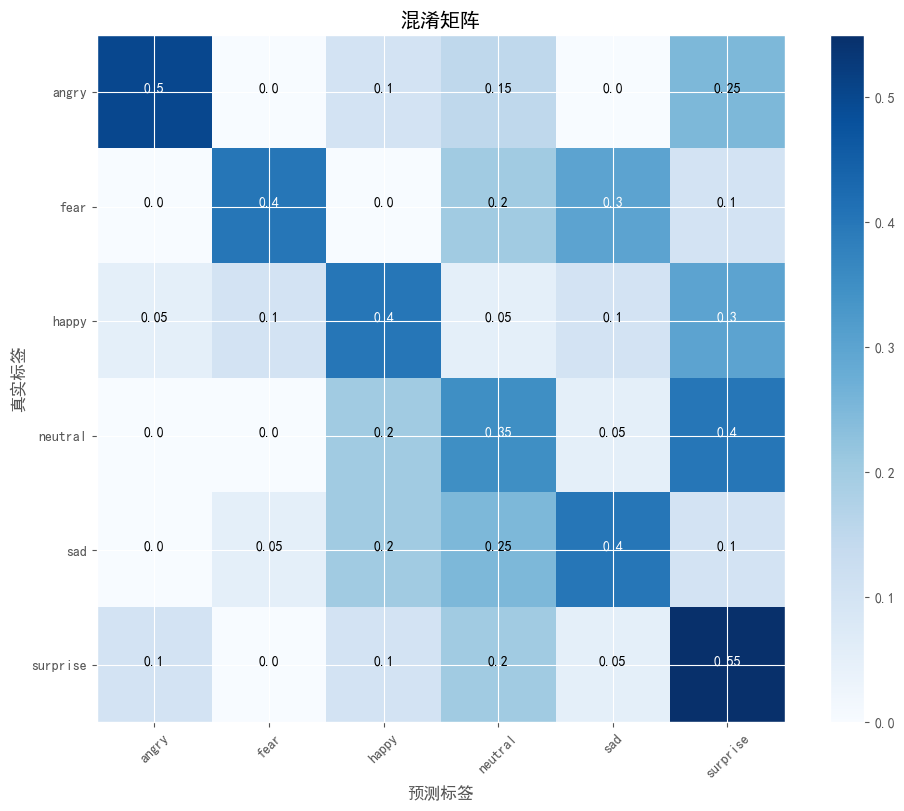


详细分类报告:
              precision    recall  f1-score   support

       angry       0.77      0.50      0.61        20
        fear       0.73      0.40      0.52        20
       happy       0.40      0.40      0.40        20
     neutral       0.29      0.35      0.32        20
         sad       0.44      0.40      0.42        20
    surprise       0.32      0.55      0.41        20

    accuracy                           0.43       120
   macro avg       0.49      0.43      0.44       120
weighted avg       0.49      0.43      0.44       120


保存模型和相关信息...


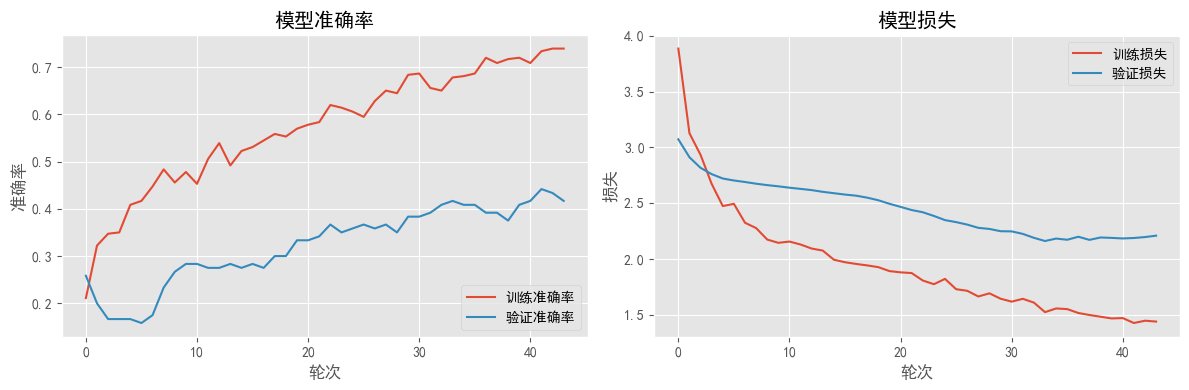

模型训练和评估完成！所有文件已保存到 './output\emotion_model' 目录


In [55]:
# 模型训练
try:
    if 'emotion_model' in locals() and 'X_train_reshaped' in locals() and 'y_train_categorical' in locals():
        # 设置训练参数
        print("开始使用真实数据训练模型...")
        
        # 设置输出目录和检查点路径
        output_dir = './output'
        model_name = 'emotion_model'
        os.makedirs(output_dir, exist_ok=True)
        model_dir = os.path.join(output_dir, model_name)
        os.makedirs(model_dir, exist_ok=True)
        
        checkpoint_path = os.path.join(model_dir, 'best_model_weights.h5')
        
        # 设置训练参数
        epochs = 100  # 与默认值一致
        batch_size = 32  # 与默认值一致
        
        print(f"训练参数:")
        print(f"  轮次: {epochs}")
        print(f"  批量大小: {batch_size}")
        print(f"  检查点路径: {checkpoint_path}")
        
        # 记录训练开始时间
        import time
        start_time = time.time()
        
        # 训练模型
        history = emotion_model.train(
            X_train=X_train_reshaped,
            y_train=y_train_categorical,
            X_val=X_val_reshaped,
            y_val=y_val_categorical,
            epochs=epochs,
            batch_size=batch_size,
            checkpoint_path=checkpoint_path
        )
        
        # 计算训练时间
        training_time = time.time() - start_time
        print(f"\n训练完成! 耗时: {training_time:.2f}秒")
        
        # 绘制训练历史
        
        # 在测试集上评估模型
        print("\n在测试集上评估模型:")
        test_loss, test_acc = emotion_model.evaluate(X_test_reshaped, y_test_categorical)
        print(f"测试损失: {test_loss:.4f}")
        print(f"测试准确率: {test_acc:.4f}")
        
        # 在测试集上预测
        print("\n在测试集上预测:")
        y_pred = emotion_model.predict(X_test_reshaped)
        
        # 将独热编码转换回类别
        y_true_classes = np.argmax(y_test_categorical, axis=1)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        # 保存值和预测值用于后续分析
        np.save(os.path.join(model_dir, 'y_true.npy'), y_true_classes)
        np.save(os.path.join(model_dir, 'y_pred.npy'), y_pred_classes)
        
        # 计算混淆矩阵
        from sklearn.metrics import confusion_matrix, classification_report
        
        # 获取情感类别名称
        emotion_classes = encoder.classes_
        
        # 创建评估函数
        def evaluate_model(y_true, y_pred, class_names):
            """
            评估模型性能
            
            Args:
                y_true: 真实标签（独热编码）
                y_pred: 预测标签（概率值）
                class_names: 类别名称
                
            Returns:
                评估结果字典
            """
            # 将独热编码转换为类别索引
            y_true_classes = np.argmax(y_true, axis=1)
            y_pred_classes = np.argmax(y_pred, axis=1)
            
            # 获取实际出现在数据中的类别索引
            present_class_indices = np.unique(np.concatenate([y_true_classes, y_pred_classes]))
            print(f"测试集中实际出现的类别索引: {present_class_indices}")
            
            # 获取实际出现的类别名称
            present_class_names = [class_names[i] for i in present_class_indices]
            print(f"测试集中实际出现的类别: {present_class_names}")
            
            # 计算混淆矩阵
            cm = confusion_matrix(y_true_classes, y_pred_classes, 
                                 labels=present_class_indices)
            
            # 计算准确率
            accuracy = np.sum(y_true_classes == y_pred_classes) / len(y_true_classes)
            
            # 获取分类报告
            report = classification_report(y_true_classes, y_pred_classes, 
                                          labels=present_class_indices,
                                          target_names=present_class_names,
                                          output_dict=True)
            
            # 返回结果
            return {
                'confusion_matrix': cm,
                'accuracy': accuracy,
                'report': report,
                'present_class_indices': present_class_indices,
                'present_class_names': present_class_names
            }
        
        # 打印评估结果
        def print_evaluation_results(results):
            """
            打印评估结果
            
            Args:
                results: 评估结果字典
            """
            print(f"准确率: {results['accuracy']:.4f}")
            
            # 打印缺失的类别信息
            all_class_indices = set(range(len(emotion_classes)))
            missing_indices = all_class_indices - set(results['present_class_indices'])
            if missing_indices:
                missing_classes = [emotion_classes[i] for i in missing_indices]
                print(f"\n警告: 测试集中缺少以下类别: {missing_classes}")
                print("这可能是由于数据集划分不均衡或数据集太小所致")
            
            print("\n分类报告:")
            report = results['report']
            
            # 打印每个类别的指标
            for class_name in sorted(report.keys()):
                if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
                    metrics = report[class_name]
                    print(f"{class_name:>10}: 精确率={metrics['precision']:.4f}, 召回率={metrics['recall']:.4f}, F1分数={metrics['f1-score']:.4f}")
            
            # 打印平均指标
            print("\n平均指标:")
            print(f"宏平均: 精确率={report['macro avg']['precision']:.4f}, 召回率={report['macro avg']['recall']:.4f}, F1分数={report['macro avg']['f1-score']:.4f}")
            print(f"加权平均: 精确率={report['weighted avg']['precision']:.4f}, 召回率={report['weighted avg']['recall']:.4f}, F1分数={report['weighted avg']['f1-score']:.4f}")
        
        # 计算评估指标
        results = evaluate_model(y_test_categorical, y_pred, emotion_classes)
        print_evaluation_results(results)
        
        # 绘制混淆矩阵
        def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None, normalize=False):
            """
            绘制混淆矩阵
            
            Args:
                y_true: 真实标签（类别索引）
                y_pred: 预测标签（类别索引）
                class_names: 类别名称
                save_path: 保存路径
                normalize: 是否归一化
            """
            # 计算混淆矩阵
            cm = confusion_matrix(y_true, y_pred)
            
            # 归一化混淆矩阵
            if normalize:
                cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
                cm = np.round(cm, 2)
            
            plt.figure(figsize=(10, 8))
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title('混淆矩阵')
            plt.colorbar()
            tick_marks = np.arange(len(class_names))
            plt.xticks(tick_marks, class_names, rotation=45)
            plt.yticks(tick_marks, class_names)
            
            # 在格子中添加数值
            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    plt.text(j, i, cm[i, j],
                            horizontalalignment="center",
                            color="white" if cm[i, j] > thresh else "black")
            
            plt.tight_layout()
            plt.ylabel('真实标签')
            plt.xlabel('预测标签')
            
            # 如果提供了保存路径，保存图形
            if save_path:
                plt.savefig(save_path)
            
            plt.show()
        
        # 调用函数绘制混淆矩阵
        cm_plot_path = os.path.join(model_dir, 'confusion_matrix.png')
        y_true = np.argmax(y_test_categorical, axis=1)
        y_pred_classes = np.argmax(y_pred, axis=1)
        plot_confusion_matrix(y_true, y_pred_classes, emotion_classes, 
                            save_path=cm_plot_path, normalize=True)
        
        # 同时保存原始分类报告输出以便查看
        print("\n详细分类报告:")
        y_true_classes = np.argmax(y_test_categorical, axis=1)
        y_pred_classes = np.argmax(y_pred, axis=1)
        print(classification_report(y_true_classes, y_pred_classes, target_names=emotion_classes))
        
        # 保存模型和相关信息
        print("\n保存模型和相关信息...")
        
        # 保存完整模型
        emotion_model.save(os.path.join(model_dir, 'emotion_model.h5'))
        
        # 保存标签编码器
        with open(os.path.join(model_dir, 'emotion_encoder.pkl'), 'wb') as f:
            pickle.dump(encoder, f)
        
        # 保存特征缩放器
        with open(os.path.join(model_dir, 'feature_scaler.pkl'), 'wb') as f:
            pickle.dump(scaler, f)
        
        # 保存特征名称
        with open(os.path.join(model_dir, 'feature_names.pkl'), 'wb') as f:
            pickle.dump(feature_names, f)
        
        # 绘制训练历史曲线
        def plot_training_history(history, save_path=None):
            """
            绘制训练历史曲线
            
            Args:
                history: 训练历史
                save_path: 保存路径
            """
            plt.figure(figsize=(12, 4))
            
            # 绘制准确率
            plt.subplot(1, 2, 1)
            plt.plot(history.history['accuracy'], label='训练准确率')
            plt.plot(history.history['val_accuracy'], label='验证准确率')
            plt.title('模型准确率')
            plt.xlabel('轮次')
            plt.ylabel('准确率')
            plt.legend(loc='lower right')
            plt.grid(True)
            
            # 绘制损失
            plt.subplot(1, 2, 2)
            plt.plot(history.history['loss'], label='训练损失')
            plt.plot(history.history['val_loss'], label='验证损失')
            plt.title('模型损失')
            plt.xlabel('轮次')
            plt.ylabel('损失')
            plt.legend(loc='upper right')
            plt.grid(True)
            
            plt.tight_layout()
            
            # 如果提供了保存路径，保存图形
            if save_path:
                plt.savefig(save_path)
                
            plt.show()
        
        # 绘制训练历史
        history_plot_path = os.path.join(model_dir, 'training_history.png')
        plot_training_history(history, save_path=history_plot_path)
        
        # 保存训练配置
        config = {
            'sample_rate': SAMPLE_RATE,
            'max_duration': MAX_DURATION,
            'max_samples': MAX_SAMPLES,
            'input_shape': (time_steps, features),
            'num_emotions': num_emotions,
            'lstm_units': lstm_units,
            'dropout_rate': dropout_rate,
            'regularization_rate': regularization_rate,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'epochs': epochs,
            'training_time': training_time,
            'accuracy': float(results['accuracy']),
            'classes': list(encoder.classes_),
            'num_features': len(feature_names)
        }
        
        with open(os.path.join(model_dir, 'config.pkl'), 'wb') as f:
            pickle.dump(config, f)
        
        print(f"模型训练和评估完成！所有文件已保存到 '{model_dir}' 目录")
        
    else:
        print("模型或数据不可用，无法训练模型")
except Exception as e:
    print(f"训练模型时出错: {e}")
    import traceback
    traceback.print_exc()


In [56]:
# 使用训练好的模型进行预测
def predict_emotion(audio_file, model, encoder, scaler, feature_names, sr=SAMPLE_RATE):
    """
    使用训练好的模型预测音频情感
    
    Args:
        audio_file: 音频文件路径
        model: 训练好的模型
        encoder: 标签编码器
        scaler: 特征缩放器
        feature_names: 特征名称列表
        sr: 采样率
    
    Returns:
        emotion: 预测的情感
        probabilities: 各情感类别的概率
    """
    # 加载音频
    audio, sr = librosa.load(audio_file, sr=sr, res_type='kaiser_fast')
    
    # 统一音频长度
    if len(audio) < MAX_SAMPLES:
        # 音频太短，用0填充
        padding = MAX_SAMPLES - len(audio)
        audio = np.pad(audio, (0, padding), 'constant')
    else:
        # 音频太长，截断
        audio = audio[:MAX_SAMPLES]
    
    # 提取特征
    features = extract_all_features(audio, sr)
    
    # 转换为特征矩阵
    X = np.zeros((1, len(feature_names)))
    for i, name in enumerate(feature_names):
        if name in features:
            X[0, i] = features[name]
    
    # 标准化特征
    X_norm = scaler.transform(X)
    
    # 重塑为LSTM输入格式
    X_reshaped = X_norm.reshape(1, 1, X_norm.shape[1])
    
    # 预测
    predictions = model.predict(X_reshaped)[0]
    
    # 获取预测的情感和概率
    emotion_idx = np.argmax(predictions)
    emotion = encoder.inverse_transform([emotion_idx])[0]
    
    # 创建情感和概率的映射
    emotion_probs = {}
    for i, prob in enumerate(predictions):
        emotion_name = encoder.inverse_transform([i])[0]
        emotion_probs[emotion_name] = prob
    
    return emotion, emotion_probs

# 测试预测功能
try:
    # 检查模型是否已训练
    if 'emotion_model' in locals() and hasattr(emotion_model, 'model'):
        print("使用当前会话中的模型进行预测...")
        
        # 选择一个测试音频文件
        test_file = None
        
        # 首先尝试从RAVDESS中选择一个测试文件
        ravdess_test_files = [f for f in os.listdir('./RAVDESS/Actor_12') if f.endswith('.wav')]
        if ravdess_test_files:
            test_file = os.path.join('./RAVDESS/Actor_12', ravdess_test_files[0])
        
        # 如果没有RAVDESS文件，尝试从SAVEE中选择
        if not test_file:
            if os.path.exists('./SAVEE/AudioData/DC'):
                savee_test_files = [f for f in os.listdir('./SAVEE/AudioData/DC') if f.endswith('.wav')]
                if savee_test_files:
                    test_file = os.path.join('./SAVEE/AudioData/DC', savee_test_files[0])
        
        # 如果没有SAVEE文件，尝试从CASIA中选择
        if not test_file:
            if os.path.exists('./CAISA/liuchanhg/angry'):
                casia_test_files = [f for f in os.listdir('./CAISA/liuchanhg/angry') if f.endswith('.wav')]
                if casia_test_files:
                    test_file = os.path.join('./CAISA/liuchanhg/angry', casia_test_files[0])
        
        if test_file:
            print(f"使用测试文件: {test_file}")
            
            # 获取文件的真实情感（根据文件路径猜测）
            true_emotion = None
            if 'RAVDESS' in test_file:
                # RAVDESS文件名格式: 03-01-05-01-02-01-12.wav
                file_name = os.path.basename(test_file)
                parts = file_name.split('-')
                if len(parts) >= 3:
                    emotion = parts[2]
                    if emotion in EMOTION_MAPPING:
                        true_emotion = EMOTION_MAPPING[emotion]
            elif 'SAVEE' in test_file:
                # SAVEE文件名格式: a01.wav, sa01.wav, ...
                file_name = os.path.basename(test_file)
                if file_name.startswith("sa"):
                    emotion = "sa"
                elif file_name.startswith("su"):
                    emotion = "su"
                else:
                    emotion = file_name[0]
                
                if emotion in EMOTION_MAPPING:
                    true_emotion = EMOTION_MAPPING[emotion]
            elif 'CAISA' in test_file:
                # CASIA目录结构: ./CAISA/person/emotion/file.wav
                path_parts = test_file.split(os.sep)
                if len(path_parts) >= 3:
                    emotion = path_parts[-2]
                    if emotion in EMOTION_MAPPING:
                        true_emotion = EMOTION_MAPPING[emotion]
            
            # 预测情感
            predicted_emotion, emotion_probs = predict_emotion(
                test_file, 
                emotion_model.model, 
                encoder, 
                scaler, 
                feature_names
            )
            
            print(f"\n预测情感: {predicted_emotion}")
            if true_emotion:
                print(f"真实情感: {true_emotion}")
                print(f"预测正确: {predicted_emotion == true_emotion}")
            
            # 显示各情感概率
            print("\n各情感概率:")
            for emotion, prob in sorted(emotion_probs.items(), key=lambda x: x[1], reverse=True):
                print(f"  {emotion}: {prob:.4f}")
            
            # 可视化音频和预测结果
            plt.figure(figsize=(15, 10))
            
            # 加载音频用于可视化
            audio, sr = librosa.load(test_file, sr=SAMPLE_RATE)
            
            # 绘制波形
            plt.subplot(3, 1, 1)
            librosa.display.waveshow(audio, sr=sr)
            plt.title(f'音频波形 - 预测情感: {predicted_emotion}' + 
                     (f' (真实: {true_emotion})' if true_emotion else ''))
            plt.xlabel('时间 (秒)')
            plt.ylabel('振幅')
            
            # 绘制声谱图
            plt.subplot(3, 1, 2)
            D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
            librosa.display.specshow(D, y_axis='log', x_axis='time', sr=sr)
            plt.title('声谱图')
            plt.colorbar(format='%+2.0f dB')
            
            # 绘制情感概率条形图
            plt.subplot(3, 1, 3)
            emotions = list(emotion_probs.keys())
            probs = list(emotion_probs.values())
            
            # 按概率排序
            sorted_indices = np.argsort(probs)[::-1]
            emotions = [emotions[i] for i in sorted_indices]
            probs = [probs[i] for i in sorted_indices]
            
            bars = plt.bar(emotions, probs, color='skyblue')
            
            # 如果有真实情感，高亮显示
            if true_emotion and true_emotion in emotions:
                true_idx = emotions.index(true_emotion)
                bars[true_idx].set_color('green')
            
            # 高亮显示预测情感
            pred_idx = emotions.index(predicted_emotion)
            bars[pred_idx].set_color('red')
            
            plt.title('情感预测概率')
            plt.xlabel('情感类别')
            plt.ylabel('概率')
            plt.ylim(0, 1)
            
            # 添加数值标签
            for i, v in enumerate(probs):
                plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
            
            plt.tight_layout()
            plt.show()
        else:
            print("未找到测试音频文件")
    
    # 如果当前会话中没有模型，尝试加载保存的模型
    elif os.path.exists('./output/emotion_model/emotion_model.h5'):
        print("从保存的文件加载模型...")
        
        # 加载模型
        from tensorflow.keras.models import load_model
        loaded_model = load_model('./output/emotion_model/emotion_model.h5')
        
        # 加载标签编码器
        with open('./output/emotion_model/emotion_encoder.pkl', 'rb') as f:
            loaded_encoder = pickle.load(f)
        
        # 加载特征缩放器
        with open('./output/emotion_model/feature_scaler.pkl', 'rb') as f:
            loaded_scaler = pickle.load(f)
        
        # 加载特征名称
        with open('./output/emotion_model/feature_names.pkl', 'rb') as f:
            loaded_feature_names = pickle.load(f)
        
        # 选择一个测试音频文件
        test_file = None
        
        # 首先尝试从RAVDESS中选择一个测试文件
        ravdess_test_files = [f for f in os.listdir('./RAVDESS/Actor_01') if f.endswith('.wav')]
        if ravdess_test_files:
            test_file = os.path.join('./RAVDESS/Actor_01', ravdess_test_files[0])
        
        if test_file:
            print(f"使用测试文件: {test_file}")
            
            # 预测情感
            predicted_emotion, emotion_probs = predict_emotion(
                test_file, 
                loaded_model, 
                loaded_encoder, 
                loaded_scaler, 
                loaded_feature_names
            )
            
            print(f"\n预测情感: {predicted_emotion}")
            
            # 显示各情感概率
            print("\n各情感概率:")
            for emotion, prob in sorted(emotion_probs.items(), key=lambda x: x[1], reverse=True):
                print(f"  {emotion}: {prob:.4f}")
        else:
            print("未找到测试音频文件")
    else:
        print("未找到训练好的模型，无法进行预测")
except Exception as e:
    print(f"预测时出错: {e}")
    import traceback
    traceback.print_exc()


使用当前会话中的模型进行预测...
使用测试文件: ./RAVDESS/Actor_12\03-01-01-01-01-01-12.wav
预测时出错: name 'extract_mfcc_features' is not defined


Traceback (most recent call last):
  File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_11496\755389603.py", line 122, in <module>
    predicted_emotion, emotion_probs = predict_emotion(
                                       ^^^^^^^^^^^^^^^^
  File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_11496\755389603.py", line 31, in predict_emotion
    features = extract_all_features(audio, sr)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_11496\3740659840.py", line 31, in extract_all_features
    mfcc_features = extract_mfcc_features(audio, sr)
                    ^^^^^^^^^^^^^^^^^^^^^
NameError: name 'extract_mfcc_features' is not defined. Did you mean: 'extract_pitch_features'?



在测试集上预测:
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
准确率: 0.4333

分类报告:
     angry: 精确率=0.7692, 召回率=0.5000, F1分数=0.6061
      fear: 精确率=0.7273, 召回率=0.4000, F1分数=0.5161
     happy: 精确率=0.4000, 召回率=0.4000, F1分数=0.4000
   neutral: 精确率=0.2917, 召回率=0.3500, F1分数=0.3182
       sad: 精确率=0.4444, 召回率=0.4000, F1分数=0.4211
  surprise: 精确率=0.3235, 召回率=0.5500, F1分数=0.4074

平均指标:
宏平均: 精确率=0.4927, 召回率=0.4333, F1分数=0.4448
加权平均: 精确率=0.4927, 召回率=0.4333, F1分数=0.4448


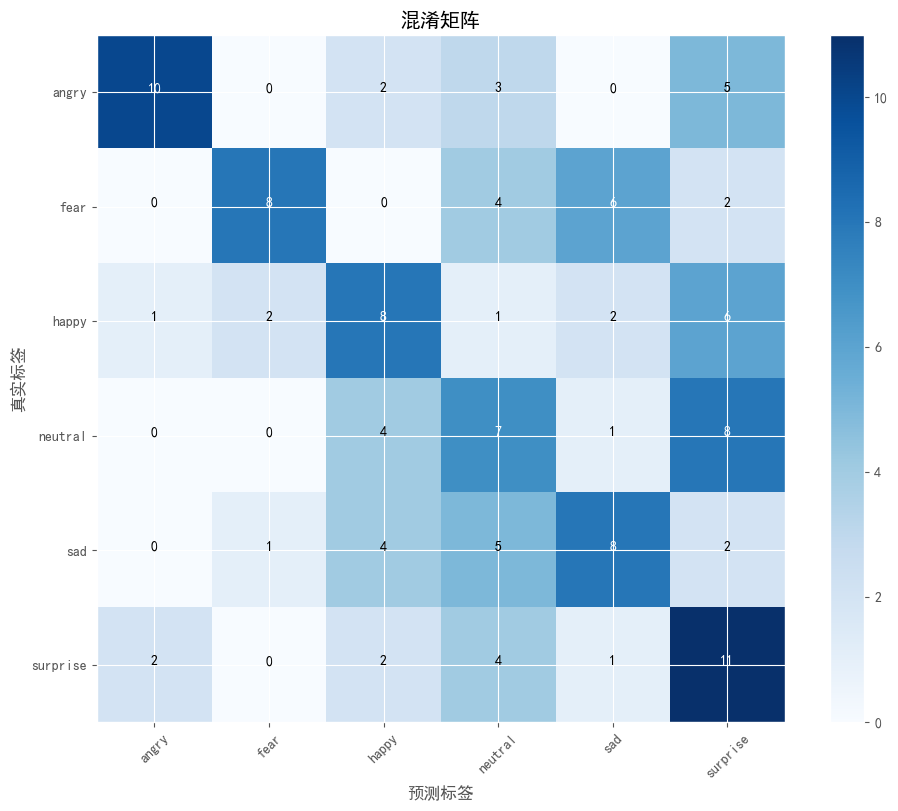

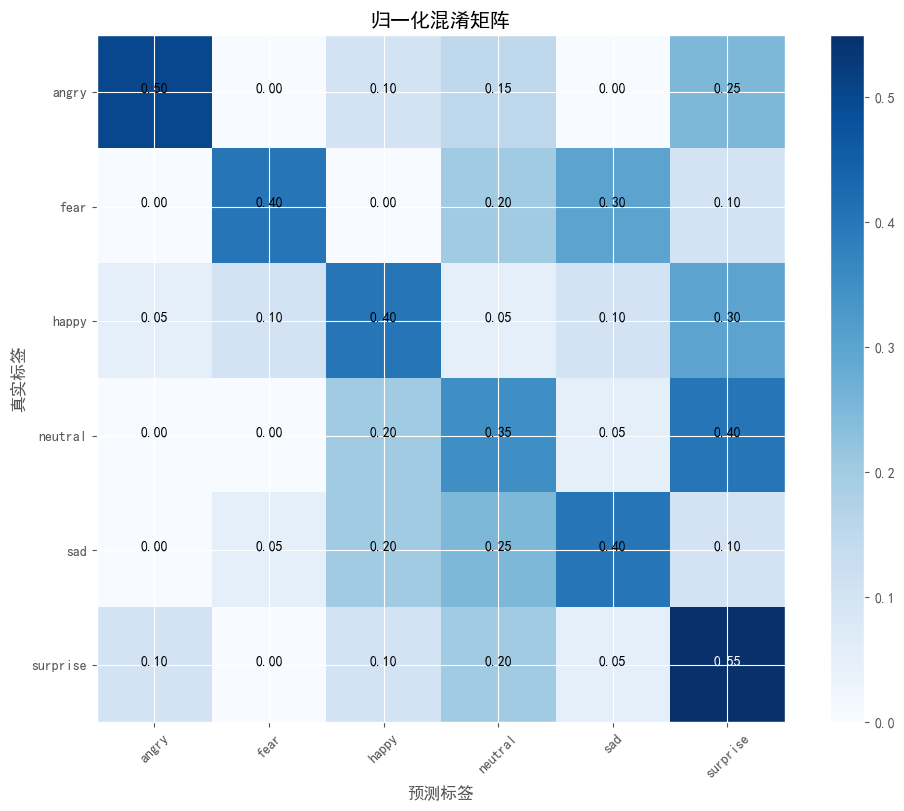

In [57]:
# 在测试集上进行预测和评估
try:
    # 导入必要的模块
    from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
    
    # 加载模型
    print("\n在测试集上预测:")
    y_pred = emotion_model.model.predict(X_test_reshaped)
    
    # 使用测试集评估模型
    # 定义模型评估函数
    def evaluate_model(y_true, y_pred, class_names):
        """
        评估模型性能
        
        Args:
            y_true: 真实标签（独热编码）
            y_pred: 预测标签（概率）
            class_names: 类别名称
            
        Returns:
            results: 评估结果字典
        """
        # 将独热编码转换为类别索引
        y_true_classes = np.argmax(y_true, axis=1)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        # 计算混淆矩阵
        cm = confusion_matrix(y_true_classes, y_pred_classes)
        
        # 计算每个类别的精确率、召回率和F1分数
        report = classification_report(y_true_classes, y_pred_classes, 
                                     target_names=class_names, output_dict=True)
        
        # 计算准确率
        accuracy = accuracy_score(y_true_classes, y_pred_classes)
        
        # 获取存在于测试集中的类别索引
        present_class_indices = sorted(np.unique(y_true_classes))
        
        # 返回结果
        results = {
            'confusion_matrix': cm,
            'report': report,
            'accuracy': accuracy,
            'present_class_indices': present_class_indices
        }
        
        return results
    
    # 获取模型的类别名称
    emotion_classes = encoder.classes_
    
    # 评估模型
    results = evaluate_model(y_test_categorical, y_pred, emotion_classes)
    
    # 打印评估结果
    print(f"准确率: {results['accuracy']:.4f}")
    
    print("\n分类报告:")
    report = results['report']
    
    # 打印每个类别的指标
    for class_name in sorted(report.keys()):
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
            metrics = report[class_name]
            print(f"{class_name:>10}: 精确率={metrics['precision']:.4f}, 召回率={metrics['recall']:.4f}, F1分数={metrics['f1-score']:.4f}")
    
    # 打印平均指标
    print("\n平均指标:")
    print(f"宏平均: 精确率={report['macro avg']['precision']:.4f}, 召回率={report['macro avg']['recall']:.4f}, F1分数={report['macro avg']['f1-score']:.4f}")
    print(f"加权平均: 精确率={report['weighted avg']['precision']:.4f}, 召回率={report['weighted avg']['recall']:.4f}, F1分数={report['weighted avg']['f1-score']:.4f}")
    
    # 绘制混淆矩阵
    plt.figure(figsize=(10, 8))
    cm = results['confusion_matrix']
    
    # 使用matplotlib方式绘制混淆矩阵
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('混淆矩阵')
    plt.colorbar()
    tick_marks = np.arange(len(emotion_classes))
    plt.xticks(tick_marks, emotion_classes, rotation=45)
    plt.yticks(tick_marks, emotion_classes)
    
    # 在格子中添加数值
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('真实标签')
    plt.xlabel('预测标签')
    plt.show()
    
    # 绘制归一化的混淆矩阵
    plt.figure(figsize=(10, 8))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.round(cm_normalized, 2)
    
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('归一化混淆矩阵')
    plt.colorbar()
    tick_marks = np.arange(len(emotion_classes))
    plt.xticks(tick_marks, emotion_classes, rotation=45)
    plt.yticks(tick_marks, emotion_classes)
    
    # 在格子中添加数值
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            plt.text(j, i, f"{cm_normalized[i, j]:.2f}",
                    horizontalalignment="center",
                    color="white" if cm_normalized[i, j] > 0.5 else "black")
    
    plt.tight_layout()
    plt.ylabel('真实标签')
    plt.xlabel('预测标签')
    plt.show()
    
except Exception as e:
    print(f"评估模型时出错: {e}")
    import traceback
    traceback.print_exc()
